# Objective
US GDP data is released every three months. Is it possible to forecast the next (in 0-3 months) GDP data release by using the data available from any source before then? Also interesting: is it possible to forecast the 2nd GDP release from today (3-6 months from now), or even the 3rd GDP release from today (6-9 months from now)?

Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using a publically available source--the ISM Report on Business, which is released on the first business dfay of every month--this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a single source of 'classically important' economic data that economists and policy makers have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Textual Data
The textual data for this notebook is from the Institue for Supply Management's (ISM) Report on Business. This report has been published on the first day of the month since the 1940's under a few different names--the most-used being the "PMI", or "Purchasing Managers Index". 

Confusingly, other research firms release data with the name "PMI", but this notebook will use the ISM's PMI report as it has the longest history.

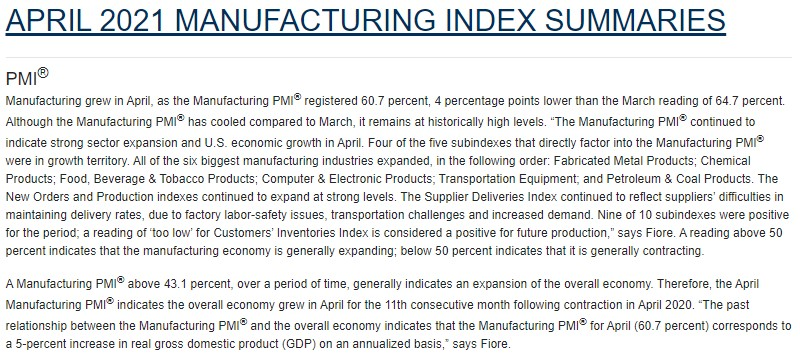


Along the numerical data in each report, the ISM summarizes the survey reponses in a few paragraphs at the beginning of the report, and for each subsection. Additionally, one sections include a selection of quotes from survey respondants. These quote's are often 'soundbite-like' and add sentiment to the report.

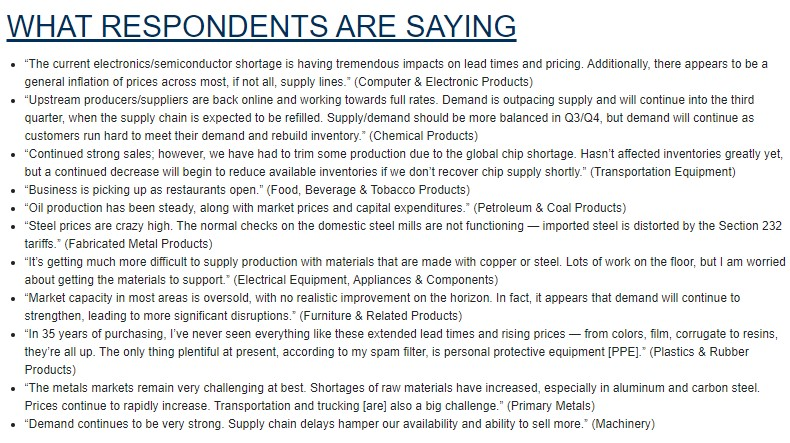



These textual summaries and quotes will be the input to the NLP model. 

## Target

The sign of the change in the GDP growth--either positive, negative. As GDP growth is the change in GDP, the target is the sign of the change of the change in GDP. This can also be described as the sign of the 2nd-order rate of change, or the acceleration, of GDP.

By choosing the target this way, this frames the problem we are solving as a binary classification problem.

The image shows the change in GDP. The target variable, as depicted in the image, is the slope of the line.

For this notebook, we will assign a positive sign to any zero change.

As GDP is reported quarterly while the ISM reports are released monthly. As a first approach to the issue of the GDP frequency being one third of the ISM frequency, we will forward-fill the GDP data series.


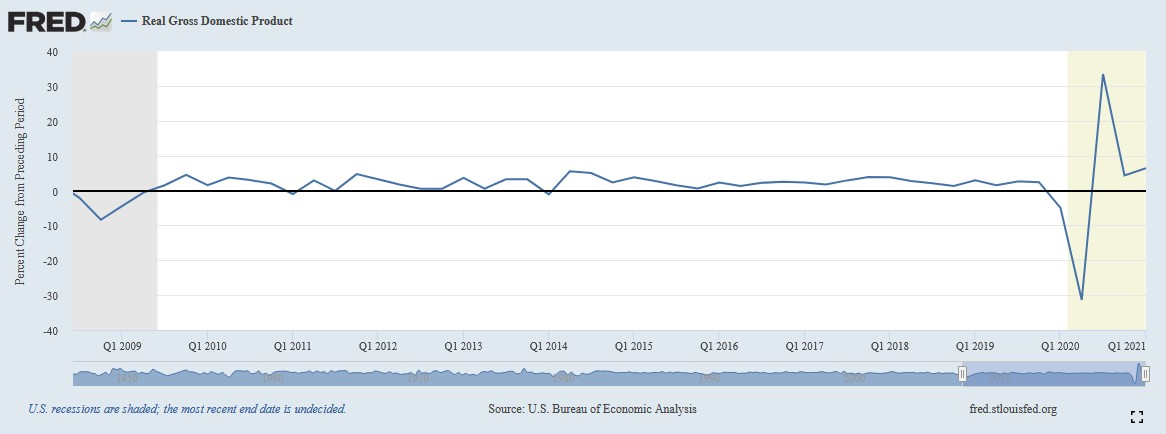

# Setup environment

## Install Modules

In [ ]:
# Clone the Github repository into temp directory and install modules from
# requirements.txt
! git clone https://github.com/allen44/endo-us-econ-analysis
! pip install -r endo-us-econ-analysis/requirements.txt

fatal: destination path 'endo-us-econ-analysis' already exists and is not an empty directory.


In [ ]:
# install chromium, its driver, and selenium
! apt update
! apt install chromium-chromedriver 

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
# install spacy
! python -m spacy download en_core_web_md
! python -m spacy validate

     |████████████████████████████████| 45.4 MB 37 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.1.2) =================
ℹ spaCy installation: /usr/local/lib/python3.7/dist-packages/spacy

NAME             SPACY            VERSION                            
en_core_web_md   >=3.1.0,<3.2.0   3.1.0   ✔



In [ ]:
# If any modules are upgraded to a more recent version, restart runtime 
# to prevent errors
# ! pip install -r requirements.txt

## Mount the GDrive storage

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/endo-us-econ-analysis'

/content/drive/MyDrive/Colab Notebooks/endo-us-econ-analysis


## Set api key variables

In [ ]:
# Set api key variables
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

# import config
# API_KEY = config.API_KEY

from pathlib import Path
import os
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-us-econ-analysis')

## Import Modules

In [ ]:
import re
import pickle
import unicodedata
import requests
import os
import pickle

import requests_cache
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import spacy

# Load contraction map
from contractions import CONTRACTION_MAP

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm


from pprint import pprint

import stanza
stanza.download('en') 

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('conll2000')

pd.options.display.max_colwidth = 200
%matplotlib inline

import model_evaluation_utils as meu

2021-08-26 20:10:02 INFO: Downloading default packages for language: en (English)...
2021-08-26 20:10:03 INFO: File exists: /root/stanza_resources/en/default.zip.
2021-08-26 20:10:08 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


# Data Retrieval with Web Scraping

The archived text of the ISM releases are hard to get, while the numerical data are easy to find. For this data, we'll scrap the news releases from PR News Wire as the ISM releases after 2012 are still available there.

## Web scraping static content with Beautiful Soup and Requests

In [ ]:
def scrap_static_website(**kwargs):
  # Unpack kwargs
  url_root = kwargs.get('url_root', 'https://www.prnewswire.com/news/institute-for-supply-management')
  urls = kwargs.get('urls', [ f'{url_root}/?page={p}&pagesize=100' \
        for p in (1, 2, 3, 4)])
  session = kwargs.get('session', requests_cache.CachedSession('news_cache'))
  headers = kwargs.get('headers', {'User-Agents': 'Mozilla/5.0',
          'referer': url_root})
  
  # Identify links of interest
  links = []
  links_suffixes = []
  for url in urls:
    # Use requests to retrieve data from a given URL
    news_response = session.get(url, headers=headers)
    # Parse the whole HTML page using BeautifulSoup
    news_soup = BeautifulSoup(news_response.text, 'html.parser')
    # Get a list of all the links
    for link in news_soup.find_all('a'):
      # print(link.get('href'))
      # print(type(link.get('href')))
      href = str(link.get('href'))
      if 'news-release' in href:
        # Filter the links to include the phrase 'PMI-at'
        if 'pmi-at' in href \
        and 'hospital' not in href \
        and 'services' not in href: 
          suffix = link.get('href').replace('/news-releases', '')
          links.append(f'{url_root}{suffix}')
          links_suffixes.append(suffix)
        # elif 'nmi-at' in str(link.get('href')):
        # links.append(link.get('href'))
  direct_links = ['https://www.prnewswire.com/news-releases'+ suffix for suffix in links_suffixes ]

  # Parse results
  res = session.get(direct_links[0])
  soup = BeautifulSoup(res.text, 'html.parser')

  return links, links_suffixes, direct_links, session, soup

(links, 
 links_suffixes, 
 direct_links,
 session,
 soup) = scrap_static_website()

len(links), len(links_suffixes), len(direct_links)

(101, 101, 101)

In [ ]:
links[:5]

['https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-59-5-july-2021-manufacturing-ism-report-on-business-301345349.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-6-june-2021-manufacturing-ism-report-on-business-301323652.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-7-april-2021-manufacturing-ism-report-on-business-301281490.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-64-7-march-2021-manufacturing-ism-report-on-business-301260206.html']

In [ ]:
# for link in links[0:2]:
print(direct_links[0])

https://www.prnewswire.com/news-releases/manufacturing-pmi-at-59-5-july-2021-manufacturing-ism-report-on-business-301345349.html


In [ ]:
# Uncomment to view the html and the soup object

# soup

Lots of info is missing from the text here, while the missing text does show correctly in a web browser. It looks like the interesting content of this page is rendered in the javascript, so we'll need a tool suitable for scraping dyanmic web pages.

## Web scraping dynamic content with Selenium

In [ ]:
def scrape_dynamic_webpages(**kwargs):
  # Unpack kwargs
  direct_links = kwargs.get('direct_links', None)
  out_page_sources_path = kwargs.get('out_page_sources_path',
                                     working_path / 'data/intermediate/page_sources/page_sources.pkl')
  out_page_urls_path = kwargs.get('out_page_urls_path', 
                                  working_path / 'data/intermediate/page_sources/page_urls.pkl')


  from selenium.webdriver import ChromeOptions, Chrome
  # from selenium.webdriver.support import expected_conditions as EC
  # from selenium.webdriver.common.by import By
  # from selenium.webdriver.support.ui import WebDriverWait

  def start_new_driver():
    # set options to be headless, ..
    options = ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    prefs = {
        # Skip loading images
        'profile.managed_default_content_settings.images':2,
        # Use disk cache
        "profile.managed_default_content_settings.images": 2,
        'disk-cache-size': 4096
        }
    options.add_experimental_option("prefs", prefs)
    # open it, go to a website, and get results
    driver = Chrome(options=options)
    return driver
  
  # Get page sources
  page_sources = []
  page_urls = []
  for direct_link in tqdm(direct_links, desc='direct_links'):
    driver = start_new_driver()
    try:
      driver.get(direct_link)
    except WebDriverException:
      #Retry once
      print('WebDriverException. Retrying once.')
      time.sleep(2)
      driver.get(direct_link)
    raw_page_source = driver.page_source
    # Unicode-normalize the source
    normalized_page_source = unicodedata.normalize('NFKD', raw_page_source)
    page_sources.append(normalized_page_source)
    page_urls.append(driver.current_url)
    driver.close()

  # Save page sources
  with open(out_page_sources_path, 'wb') as f:
    pickle.dump(page_sources, f)
  with open(out_page_urls_path, 'wb') as f:
    pickle.dump(page_urls, f)

  return page_sources, page_urls

In [ ]:
# # Uncomment to load selenium and scrape the URLs

# (page_sources, 
#  page_urls) = scrape_dynamic_webpages(direct_links=direct_links)
# len(page_sources), len(page_urls)

In [ ]:
# Load page sources with this cell, or uncomment cell above to scrape fresh data (it's slow)
page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
with open(page_sources_path, 'rb') as f:
  page_sources = pickle.load(f)

page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
with open(page_sources_path, 'rb') as f:
  page_urls =  pickle.load(f)

len(page_sources), len(page_urls)

(101, 101)

In [ ]:
normalized_page_sources = []
for raw_page_source in page_sources:
  normalized_page_sources.append(unicodedata.normalize('NFKD', raw_page_source))
page_sources = normalized_page_sources

# Assert that all urls and page_sources are unique
df = pd.DataFrame({'url': page_urls, 'page_source': page_sources})
assert df['url'].is_unique
assert df['page_source'].is_unique

len(page_sources)

101

## Parse the Release body

In [ ]:
#Parse release_bodies from page source
releases = []
paragraphs_all_releases_soup = []
paragraphs_all_releases_text = []
for i, release_page_source in enumerate(page_sources):
  # print(release_page_source)
  release = {}
  soup = BeautifulSoup(release_page_source, 'html.parser')
  release['release_body'] = soup.find('section', 'release-body')
  paragraphs_this_release = release['release_body'].find_all('p')
  release['paragraphs'] =  paragraphs_this_release
  for paragraph in paragraphs_this_release:
    paragraphs_all_releases_soup.append(paragraph)
    paragraphs_all_releases_text.append(paragraph.text)
  # Select the first date in the release body
  date = release['release_body'].select('span.xn-chron')[1].text
  # print(date)
  # print(release['paragraphs'][0:5])
  release['date'] = date
  releases.append(release)
len(releases), len(paragraphs_all_releases_soup), len(paragraphs_all_releases_text)

(101, 64238, 64238)

#### Tests: Check the properties of the release bodies

In [ ]:
# check to make sure the release bodies are unique
df = pd.DataFrame.from_dict(releases)
assert df['release_body'].is_unique
assert df['paragraphs'].apply(repr).is_unique

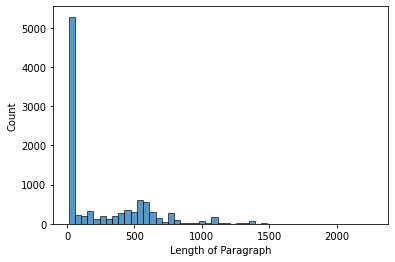

In [ ]:
# Compare number of paragraphs in different releases to see if the number is constant,
# which would indicate a stable paragraph structure in the text
lengths = []
for paragraph_text in paragraphs_all_releases_text:
  # ignore paragraphs shorter than 10:
  if len(paragraph_text)>10:
    lengths.append(len(paragraph_text)) 
lengths_hist = sns.histplot(lengths)
lengths_hist.set(xlabel='Length of Paragraph');

No conclusion can be made with the paragraph structure alone. There are lots of zero-length paragraphs.

In [ ]:
# check for paragraphs that are repeated accross multiple releases.
all_paragraphs_series = pd.Series(paragraphs_all_releases_text, name='paragraphs_all_releases_text')
all_paragraphs_series.is_unique

False

Some paragraphs  not unique. What are the most common paragraphs?


We see that there are non-unique paragraphs in the corpus. Which are they?

In [ ]:
all_paragraphs_series.value_counts()

Index                                                                                                                                                                                                                                                                                                                                                                                                                                                               1114
Net                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1010
%Same                                                                                 

## Identify Relevant Paragraphs from Release Body


The paragraphs groups of interest are:
* Summary
* What Respondants are Saying 
* Commodities Up in Price 
* Commodities Down in Price 
* Commodities in Short Supply

Other paragraphs will not be included in this notebook.

All the PMI reports include the same paragraph groups, except for minor and infrequent changes to format, such as when the ISM changed the name of the report from PMI to Manufacturing PMI.

### Summary

In [ ]:
# Parse from the top and group the text as the first group, summary. 
# Stop parsing upon encountering the string: 'WHAT RESPONDENTS ARE SAYING'

import dateutil.parser

def parse_summary(paragraphs: bs4.element.ResultSet):
  summary_paragraphs_by_release = []
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # fix unicode change to a common string, PMITM to PMI
    text = re.sub('( PMITM )|( PMI® )', ' PMI ', text)
    if not text:
      # Some paragraphs are exclusively whitespace, so exclude these
      continue
    elif re.match('.*DO NOT CONFUSE THIS NATIONAL REPORT.*', text):
      # Exclude this non-informative paragraph that only clarifies that this 
      # report is not the same  as another report
      continue
    elif re.match('^.+\/PRNewswire\/ -- ', text):
      # Remove this portion of paragraph, containing only the location, date and byline of the news outlet
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^.+\/PRNewswire\/ -- ', '', text))
    elif re.match('^The report was issued today by.*Survey Committee.\s', text):
      # Remove this portion of paragraph, containing only person presenting the report
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^The report was issued today by.*Survey Committee.\s', '', text))
    elif 'WHAT RESPONDENTS ARE SAYING' in text:
      #End of summary section; beginning of next section
      break
    else:
      summary_paragraphs_by_release.append(text)
  return summary_paragraphs_by_release

summary_paragraphs_by_release = [parse_summary(release['paragraphs']) for release in releases]
len(summary_paragraphs_by_release)

101

In [ ]:
summary_paragraphs_by_release[0]

["New Orders, Production, & Employment Growing; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices Increasing; Exports and Imports Growing",
 "Economic activity in the manufacturing sector grew in July, with the overall economy notching a 14th consecutive month of growth, say the nation's supply executives in the latest Manufacturing ISM® Report On Business®.",
 'The report was issued today by Timothy R. Fiore, CPSM, C.P.M., Chair of the Institute for Supply Management® (ISM®) Manufacturing Business Survey Committee:',
 '"The July Manufacturing PMI registered 59.5 percent, a decrease of 1.1 percentage points from the June reading of 60.6 percent. This figure indicates expansion in the overall economy for the 14th month in a row after contraction in April 2020. The New Orders Index registered 64.9 percent, decreasing 1.1 percentage points from the June reading of 66 percent. The Production Index regi

In [ ]:
summary_paragraphs_flat_by_release = []
for summary_paragraphs in summary_paragraphs_by_release:
  summary_paragraphs_flat_by_release.append(' '.join(summary_paragraphs))

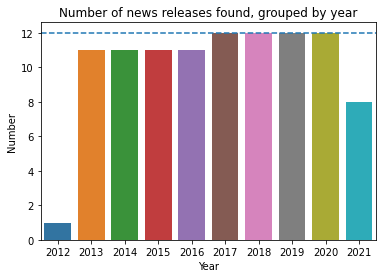

In [ ]:
def parse_date(paragraphs: bs4.element.ResultSet):
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # Parse the date from this paragraph
    match = re.match('^.+\/PRNewswire\/ -- ', text)
    if match:
      # print(paragraph)
      date_string = paragraph.select('span.xn-chron')[0].text
      return pd.to_datetime(date_string)

# Parse dates
release_dates = [parse_date(release['paragraphs']) for release in releases]
dates_count = pd.Series(release_dates).dt.year.value_counts()

# Plot
ax = sns.barplot(x=dates_count.index,
            y=dates_count)
ax.axhline(12, linestyle='--')
ax.set(title='Number of news releases found, grouped by year',
       ylabel='Number',
       xlabel='Year')
plt.show()

We can see that there are some missing months. 

Except for starting year (2012) and the ending year (2021), we expect that there should be twelve releases per year. However, we see some years with only eleven releases.
These releases are missing from the news relese source, so there's no scraping techinique we could use to get that data from the same news site, unfortunately.

Missing years and month: 
* 2013: March,
* 2014: May, 
* 2015: August, 
* 2016: November

In [ ]:
summary_paragraphs[0]

"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's supply executives in the latest Manufacturing ISM Report On Business®."

### What Respondants are Saying

This section contain quotes from the anonymous supply managers responding to the survey. These quotes may be cherry-picked by the decision makers who compile the report, but this section of the report is probably the most useful as an input into and NLP sentiment analysis model.

In [ ]:
# abbreviation: wras = what_respondants_are_saying
def parse_wras(releases: list):
  wras_soups = []
  wras_texts = []
  wras_soups_flat = []
  wras_texts_flat = []
  for release in tqdm(releases):
    wras_soup = release['release_body'].find_all('li')
    wras_soups.append(wras_soup)

    wras_text = [unicodedata.normalize('NFKD', tag.text.strip()) for tag in wras_soup]
    wras_texts.append(wras_text)
    
    for tag in wras_soup:
      wras_soups_flat.append(tag)
    for text in wras_text:
      wras_texts_flat.append(text)
  assert len(wras_soups)==len(wras_texts)
  assert len(wras_soups_flat)==len(wras_texts_flat)
  return (wras_soups,  # List of lists of soups
          wras_texts,    # List of lists of texts
          wras_soups_flat, # lists of soups
          wras_texts_flat) # lists of texts

(wras_soups,
  wras_texts,  
  wras_soups_flat,
  wras_texts_flat) = parse_wras(releases)  

len(wras_soups), len(wras_texts), len(wras_soups_flat), len(wras_texts_flat)

  0%|          | 0/101 [00:00<?, ?it/s]

(101, 101, 1019, 1019)

In [ ]:
wras_texts[:1]

[['"Business levels continue to exhibit strong demand, with no signs of backing down. Purchases continue to have long lead times due to shortages of raw materials and labor force, as well as logistics challenges. Increased costs are being passed to customers." [Computer & Electronic Products]',
  '"Supply chains are slowly, very slowly filling up. Like a water hose, starting upstream and slowly flowing downstream. Rumor is a full return to \'normal\' may be nearer to year\'s end, but the situation is progressing. Transportation (equipment and drivers) is the current pinch point, more so than material shortages." [Chemical Products]',
  '"Strong sales continue, and inventories are low as the chip shortage is keeping production numbers down — we have idled several of our assembly plants to reduce the strain on the chip supply base." [Transportation Equipment]',
  '"Still dealing with price increases from force majeure issues as well as overseas shipping premiums and higher costs of items

#### Parse WRAS quote and industry

In [ ]:
wras_tuples_by_release = []
wras_tuples_flat = []
for quote_and_ind_str_list in wras_texts:
  inner_wras_tuples = []
  for quote_and_ind_str in quote_and_ind_str_list:
    match_0 = re.match('\"?(.+)\"?\s\((.*)\)', quote_and_ind_str)
    match_1 = re.match('"(.*")\s+[/(/[]([A-Z].*)[\]\)]', quote_and_ind_str)
    if match_0:
      # print(match_0)
      # print(match_0.group(1)[:20], match_0.group(2))
      inner_wras_tuples.append((match_0.group(1), match_0.group(2)))
      wras_tuples_flat.append((match_0.group(1), match_0.group(2)))
    elif match_1:
      # print(match_1)
      # print(match_1.group(1)[:20], match_1.group(2))
      inner_wras_tuples.append((match_1.group(1), match_1.group(2)))
      wras_tuples_flat.append((match_1.group(1), match_1.group(2)))
    else:
      # Too few to matter (<4), ignore precessing these outliers; just append as-is
      # print(quote_and_ind_str)
      continue
  wras_tuples_by_release.append(inner_wras_tuples)

len(wras_tuples_by_release), len(wras_tuples_flat)

(101, 1018)

In [ ]:
wras_tuples_by_release[:1]

[[('Business levels continue to exhibit strong demand, with no signs of backing down. Purchases continue to have long lead times due to shortages of raw materials and labor force, as well as logistics challenges. Increased costs are being passed to customers."',
   'Computer & Electronic Products'),
  ("Supply chains are slowly, very slowly filling up. Like a water hose, starting upstream and slowly flowing downstream. Rumor is a full return to 'normal' may be nearer to year's end, but the situation is progressing. Transportation",
   'equipment and drivers'),
  ('Strong sales continue, and inventories are low as the chip shortage is keeping production numbers down — we have idled several of our assembly plants to reduce the strain on the chip supply base."',
   'Transportation Equipment'),
  ('Still dealing with price increases from force majeure issues as well as overseas shipping premiums and higher costs of items like fuel. Customer demand still high; pushing plant to max productio

In [ ]:
wras_texts_by_release = []
wras_texts_flat_by_release = []
wras_industries_by_release = []
wras_industries_flat_by_release = []
for wras_tuples in wras_tuples_by_release:
  wras_text, wras_industries = zip(*wras_tuples)
  wras_text_flat = ' '.join(wras_text)
  wras_industries_flat = ' '.join(wras_industries)

  wras_texts_by_release.append(wras_text)
  wras_texts_flat_by_release.append(wras_text_flat)
  wras_industries_by_release.append(wras_industries)
  wras_industries_flat_by_release.append(wras_industries_flat)

### Commodities Up, Down, and in short supply

This section is not likely to be useful for a sentiment analysis. But, this does appear to be a useful source of categorical data that could later be transformed into usefuls numerical series as an input to any model.

One possible modelling application would be to test a hypothesis that the data in this section is a leading indicator of commodity prices.

#### Parse commodites up/down in price and short supply from Paragraphs

In [ ]:
comm_up_lists = []
comm_down_lists = []
comm_short_lists = []
comm_up_lists_flat = []
comm_down_lists_flat = []
comm_short_lists_flat = []
for i, release in enumerate(releases):
  # Up
  comm_up_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').get_text().replace('Commodities Up in Price', '').strip())
  if not comm_up_inter_str:
    # print('if up_4')
    comm_up_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  
  if re.match('The only commodity listed up in price.+is\s',comm_up_inter_str):
    # print('up_match_1')
    comm_up_str = re.sub('The only commodity listed up in price.+is\s', '', comm_up_inter_str)
  else:
    comm_up_str = comm_up_inter_str
  
  if re.search('Commodities', comm_up_str):
    comm_up_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('span').get_text().replace('Commodities Up in Price', '').strip()
  
  # Source forgot a semi-colon one time
  if comm_up_inter_str == 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2) and Steel Products* (10).':
    comm_up_str = 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2); and Steel Products* (10).'
  
  assert comm_up_str
  assert not re.search('Commodities', comm_up_str)
  # print(i, '\t', comm_up_str)

  # Down
  comm_down_heading_text = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice'))
  if comm_down_heading_text:
    if 'Up' in comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip():
      # print('if Up')
      comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent().find_parent().get_text()
    else:
      comm_down_inter_str = comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if down_4')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  else:
    # print('if 2')
    comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if 3')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.next_sibling.get_text()
  assert comm_down_str
  assert not re.search('Commodities', comm_down_str)
  # print(i, '\t', comm_down_str) 

  # Short
  comm_short_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('p').get_text().replace('Commodities in Short Supply', '').strip())
  if re.match('[Nn]o\scommodities\s.*\sshort\ssupply',comm_short_inter_str):
    # print(i, 'short_match_1')
    comm_short_str = re.sub('.*[Nn]o\scommodities\s.*\sshort\ssupply.*', 'None.', comm_short_inter_str)
  elif re.match('.*\sis\sthe\sonly\scommodity.*',comm_short_inter_str):
    # print(i, 'short_match_2')
    comm_short_str = re.sub('\sis\sthe\sonly\scommodity.*', '', comm_short_inter_str)
  elif re.match('.*no commodities listed in short supply.*', comm_short_inter_str):
    # print(i, 'short_match_3')
    comm_short_str = re.sub('^.*no commodities listed in short supply.*', 'None.', comm_short_inter_str)
  elif re.match('The only commodity.*short supply.*is\s', comm_short_inter_str):
    # print(i, 'short_match_4')
    comm_short_str = re.sub('The only commodity.*short supply.*is\s', '', comm_short_inter_str)
  elif re.match('Commodities\s.*in', comm_short_inter_str):
    # print(i, 'short_match_5')
    comm_short_str = release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('span').get_text().replace('Commodities in Short Supply ', '').strip()
  else:
    comm_short_str = comm_short_inter_str
  assert comm_short_str
  assert not re.search('Commodities', comm_short_str)

  # if re.match('Commodities\s.*in', comm_short_str):
  #   print(i, comm_short_str)
  #   raise
  # print(i, '\t', comm_short_str)
  # print(comm_short_str)
  
  # Remove any final '.'
  comm_up_list = re.sub('\.$', '', comm_up_str)
  comm_down_list = re.sub('\.$', '', comm_down_str)
  comm_short_list = re.sub('\.$', '', comm_short_str)

  # Split string into list at ';'
  comm_up_list = comm_up_str.split('; ')
  comm_down_list = comm_down_str.split('; ')
  comm_short_list = comm_short_str.split('; ')

  # # strip white space
  comm_up_list = [ele.strip() for ele in comm_up_list]
  comm_down_list = [ele.strip() for ele in comm_down_list]
  comm_short_list = [ele.strip() for ele in comm_short_list]

  # Append to list
  comm_up_lists.append(comm_up_list)
  comm_down_lists.append(comm_down_list)
  comm_short_lists.append(comm_short_list)

  for ele in comm_up_list:
    comm_up_lists_flat.append(ele)
  for ele in comm_down_list:
    comm_down_lists_flat.append(ele)
  for ele in comm_short_list:
    comm_short_lists_flat.append(ele)


In [ ]:
# Check lengths
len(comm_up_lists), len(comm_down_lists), len(comm_short_lists)

(101, 101, 101)

In [ ]:
# Check lengths
len(comm_up_lists_flat), len(comm_down_lists_flat), len(comm_short_lists_flat)

(1447, 578, 484)

#### Parse commodities and months Up/Down/Short-supply from "Commodites Up/Down in Price and Short Supply"

In [ ]:
def parse_commodities_up_down_short_string(commodity_str, debug=False):
  # Remove unicode and Replace *
  commodity_str = unicodedata.normalize('NFKD', commodity_str).replace('*', '')

  # Check for 'None'
  match_none_no_digits = re.match('^None.$', commodity_str)
  match_none_digits = re.match('^None\s\((\d+)\)\.$', commodity_str)

  # Check for 'no commoditites are...'
  match_no_commod_no_digits = re.match('No commodities are', commodity_str)
  match_no_commod_digits = re.match('No commodities are.* \((\d+)\)', commodity_str)
  # Check for 'only commodity...'
  match_only_commodity_digits = re.match('(.+) \((\d+)\) is the only commodity.*', commodity_str)
  match_only_commodity_no_digits = re.match('([A-Z0-9#].*) is the only commodity.+\.', commodity_str)
  
  if match_none_no_digits or match_no_commod_no_digits:
    commod_str = 'None'
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_none_no_digits or match_no_commod_no_digits')
      print(commodity_str)
      print(tup)
  elif match_none_digits:
    commod_str = 'None'
    digits = int(match_none_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_none_digits')
      print(commodity_str)
      print(tup)
  elif match_no_commod_digits:
    commod_str = 'None'
    digits = int(match_no_commod_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_no_commod')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_no_digits:
    commod_str = match_only_commodity_no_digits.group(1)
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_digits:
    commod_str = match_only_commodity_digits.group(1)
    digits = match_only_commodity_digits.group(2)
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  else:
    # Check for 'and...commod_str..(digits)
    match_2 = re.match('^and\s([A-Z#\d].*)\s\((\d+)\)', commodity_str) # and..., with no period at end
    match_3 = re.match('^and\s(.*)', commodity_str)
    if match_2:
      commod_str = match_2.group(1)
      digits = int(match_2.group(2))
      tup = (commod_str, digits)
      if debug:
        print('match_2')
        print(commodity_str)
        print(i, match_2.groups())
        print(tup)
    elif match_3:
      commod_str = re.sub('\.$', '', match_3.group(1))
      digits = 1
      tup = (commod_str, digits)
      if debug:
        print('match_3')
        print(commodity_str)
        print(i, match_3.groups())
        print(tup)
    else:
      # Check for 'comod_str...(digits)
      match_4 = re.match('^([A-Z0-9#].*)\s\((\d+)\)$', commodity_str)
      match_5 = re.match('^([A-Z0-9#].*)', commodity_str)
      if match_4:
        commod_str = match_4.group(1)
        digits = int(match_4.group(2))
        tup = (commod_str, digits)
        if debug:
          print('match_4')
          print(commodity_str)
          print(i, match_4.groups())
          print(tup)
      elif  match_5:
        commod_str = match_5.group(1)
        digits = 1
        tup = (commod_str, digits)
        if debug:
          print('match_5')
          print(commodity_str)
          print(i, match_5.groups())
          print(tup)
      else:
        # If it doesn't match any ohter regular expression
        print(i, commodity_str)
        raise Error
  return tup

In [ ]:
commodities_up_by_release = []
for comm_up_list in comm_up_lists:
  this_release = []
  for commod_up in comm_up_list:
    this_release.append(parse_commodities_up_down_short_string(commod_up))
  commodities_up_by_release.append(this_release)

commodities_down_by_release = []
for comm_down_list in comm_down_lists:
  this_release = []
  for commod_down in comm_down_list:
    this_release.append(parse_commodities_up_down_short_string(commod_down))
  commodities_down_by_release.append(this_release)

commodities_short_by_release = []
for comm_short_list in comm_short_lists:
  this_release = []
  for commod_short in comm_short_list:
    this_release.append(parse_commodities_up_down_short_string(commod_short))
  commodities_short_by_release.append(this_release)

In [ ]:
len(commodities_up_by_release), len(commodities_down_by_release), len(commodities_short_by_release)

(101, 101, 101)

In [ ]:
commodities_names_up_by_release = []
commodities_names_up_flat_by_release = []
for tup in commodities_up_by_release:
  commodities_names_up, _ = zip(*tup)
  commodities_names_up_by_release.append(commodities_names_up)
  commodities_names_up_flat_by_release.append(', '.join(commodities_names_up))

commodities_names_down_by_release = []
commodities_names_down_flat_by_release = []
for tup in commodities_down_by_release:
  commodities_names_down, _ = zip(*tup)
  commodities_names_down_by_release.append(commodities_names_down)
  commodities_names_down_flat_by_release.append(', '.join(commodities_names_down))

commodities_names_short_by_release = []
commodities_names_short_flat_by_release = []
for tup in commodities_short_by_release:
  commodities_names_short, _ = zip(*tup)
  commodities_names_short_by_release.append(commodities_names_up)
  commodities_names_short_flat_by_release.append(', '.join(commodities_names_short))

##### Check Outputs

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_names_up_by_release)):
#   print(f'{i},\t{comm_up_lists[i][0]},\t{commodities_up_by_release[i][0]}')

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_down_by_release)):
#   print(f'{i},\t{comm_down_lists[i][0]},\t{commodities_down_by_release[i][0]}')

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_short_by_release)):
#   print(f'{i},\t{comm_short_lists[i][0]},\t{commodities_short_by_release[i][0]}')

## Variables for further use:

`summary_paragraphs`,
`wras_tuples`,
`commodities_up`,
`commodities_down`,
`commodities_short`,

### Check the variables

In [ ]:
# summary_paragraphs[0]

In [ ]:
# wras_texts_flat_by_release[2]

In [ ]:
# commodities_up_by_release[0]

In [ ]:
# commodities_down_by_release[0]

In [ ]:
# commodities_short_by_release[0]

## Make dataframes from parsed variables

In [ ]:
dates_ser = pd.Series(release_dates, name='date')

summary_ser = pd.Series( summary_paragraphs_flat_by_release, 
                        name='summary')

wras_text_ser = pd.Series(wras_texts_flat_by_release, name='wras')

commodities_up_ser = pd.Series(commodities_names_up_flat_by_release, name='commodities_up_in_price')
commodities_up_count_ser = pd.Series([len(commodities_up) for commodities_up in commodities_up_by_release], 
                                     name='commodities_up_count')

commodities_down_ser = pd.Series(commodities_names_down_flat_by_release, name='commodities_down_in_price')
commodities_down_count_ser = pd.Series([len(commodities_down) for commodities_down in commodities_down_by_release], 
                                       name='commodities_down_count')

commodities_short_ser = pd.Series(commodities_names_short_flat_by_release, name='commodities_in_short_supply')
commodities_short_count_ser = pd.Series([len(commodities_short) for commodities_short in commodities_short_by_release], 
                                        name='commodities_short_count')

df = pd.DataFrame(data=[dates_ser,
                        summary_ser,
                        wras_text_ser,
                        commodities_up_ser,
                        commodities_up_count_ser,
                        commodities_down_ser,
                        commodities_down_count_ser,
                        commodities_short_ser,
                        commodities_short_count_ser]).T
df['date'] = pd.to_datetime(df['date'])
df['summary'] = df['summary'].astype('string')
df['wras'] = df['wras'].astype('string')
df['commodities_up_count'] = df['commodities_up_count'].astype(int)
df['commodities_down_count'] = df['commodities_down_count'].astype(int)
df['commodities_short_count'] = df['commodities_short_count'].astype(int)
df = df.set_index('date').sort_index()

##Get the target variable

In [ ]:
# Set api key variables
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY

import pandas_datareader as pdr
import datetime
import requests_cache

# Get data from FRED
expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime.today()

params = {
    'api_key': API_KEY['fred']
                }
gdp_growth = pdr.fred.FredReader('A191RP1Q027SBEA', 
                          start, end, 
                          session=session).read().squeeze().rename('gdp_growth')
gdp_growth.index = gdp_growth.index.rename('date')

# Get the sign of the change in gdp growth
# Make the  value 0 if sign is negative or zero, else: 1.
gdp_growth_direction = (gdp_growth.diff()
                                  .dropna()
                                  .apply(np.sign)
                                  .map({-1:0, 0:1, 1:1,})
                                  .rename('gdp_growth_direction')
                                  .resample('D').ffill())
# Add the target to the dataframe
df = df.join(gdp_growth_direction)

# Check the dataframe
df.sample(5)

,summary,wras,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_in_short_supply,commodities_short_count,gdp_growth_direction
date,,,,,,,,,
2019-02-01,"New Orders, Production, and Employment Growing; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Decreasing; E...","Unlike in the last few years, we are experiencing a first quarter slowdown."" Steady supply and production environment."" Concerns about oil prices are fueling questions of how strong the economy wi...","Electronic Components, Freight, Nylon Polymer, Printed Circuit Board Assemblies, Printed Circuit Boards, Steel, Steel — Hot Rolled, Steel — Stainless, Steel Products, Sulfuric Acid, Valves",11,"Aluminum, Base Oils, Caustic Soda, Copper, Diesel, Gasoline, Memory, Polyethylene, Polypropylene, Steel, Steel — Carbon, Steel — Hot Rolled, Steel — Stainless, Steel Products, Steel Scrap",15,"Capacitors, Electrical Components, Electronic Components, Integrated Circuits, Nylon Polymer, Resistors",6,1.0
2019-01-03,"New Orders, Production, and Employment Growing Supplier Deliveries Slowing at Slower Rate; Backlog Unchanged Raw Materials Inventories Growing; Customers' Inventories Too Low Prices Increasing at ...","Growth appears to have stopped. Resources still focused on re-sourcing for U.S. tariff mitigation out of China."" Brexit has become a problem due to labeling changes."" Customer demand continues to ...","Chemicals, Electrical Components, Electronic Components, Freight, Labor — Construction, Metal-Based Products, Natural Gas, PET Resin, Printed Circuit Boards, Steel, Steel-Based Products",11,"Aluminum, Caustic Soda, Crude Oil, Gasoline, Steel, Steel — Hot Rolled",6,"Capacitors, Electronic Components, Hardwood, Labor, Resistors, Steel, Steel-Based Products",7,1.0
2014-11-03,"Economic activity in the manufacturing sector expanded in October for the 17th consecutive month, and the overall economy grew for the 65th consecutive month, say the nation's supply executives in...","Holiday orders are exceeding seasonal forecasts. Customers are demanding additional quantities above prior orders. Fuel costs and other positive signals appear to be creating demand above normal.""...","Aluminum, Electrical Components, MRO Supplies, Polyethylene, Polypropylene, Stainless Steel",6,"Aluminum, Carbon Steel, Copper, Corn-Based Products, Diesel, Galvanized Steel, Gasoline, Silver",8,Electronic Components.,1,0.0
2015-11-02,"Economic activity in the manufacturing sector expanded in October for the 34th consecutive month, and the overall economy grew for the 77th consecutive month, say the nation's supply executives in...","Demand remains steady with three percent top line unit growth. [Dollar] ($) sales are flat due to currency and cost changes."" Currency exchange is having a large impact on business results."" Energ...","Aluminum, Copper",2,"Aluminum, Gasoline, HDPE Resin, Nickel, Oil, Plastic Resins, Polyethylene Resin, Steel, Steel – #1 Busheling Scrap, Steel – Cold Rolled, Steel – Hot Rolled, Steel – Galvanized, Scrap Steel, Stainl...",15,"Carbon Dioxide, Electronic Components",2,0.0
2016-08-01,"Economic activity in the manufacturing sector expanded in July for the fifth consecutive month, while the overall economy grew for the 86th consecutive month, say the nation's supply executives in...","With Brexit, keeping [a] close eye on how this will impact our business."" Stronger than expected end to Q2 (June) saw us beat our forecast which is the first time in five quarters, though we were ...","Copper, Corrugate, Dairy, Diesel, Gold, Natural Gas, Petroleum Based Products, Polyethylene Resins, Stainless Steel, Steel, Steel — Carbon, Steel — Hot Rolled",12,"Copper, Corn, Corrugate, Steel",4,None,1,0.0


### Visualize the target variable

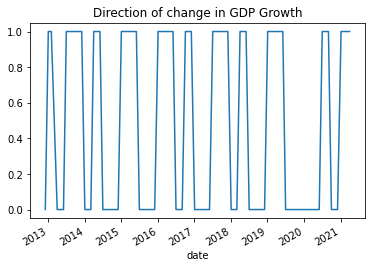

In [ ]:
df['gdp_growth_direction'].plot()
plt.title('Direction of change in GDP Growth');

The target variable looks stationary. 

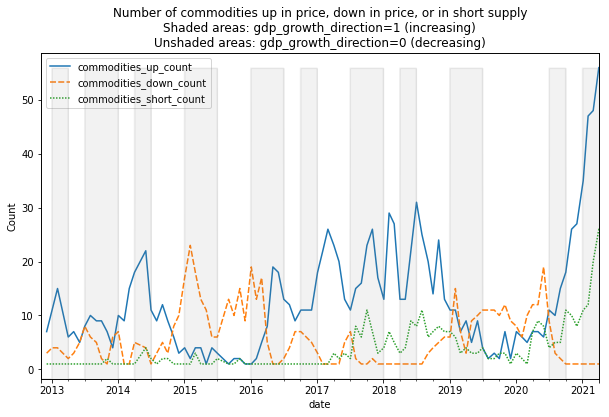

In [ ]:
# Visualize the relationship between the numerical features and target
fig, ax1 = plt.subplots(figsize=(10,6)) # initializes figure and plots
ax2 = ax1.twinx()

g = sns.lineplot(data=df.drop(columns=['gdp_growth_direction']), ax=ax1)
g.set(ylabel='Count',
      title='Number of commodities up in price, down in price, or in short supply\nShaded areas: gdp_growth_direction=1 (increasing)\nUnshaded areas: gdp_growth_direction=0 (decreasing)');

gdp_growth_direction['2012-11':].plot.area(ax=ax2, alpha=0.1, color='grey')
plt.yticks([]) # hide yticks of second axis
plt.show()

We don't see an obvious relationship between the target variable and the numerical features.

We can see from the plot that, recently, more commodities are up in price than at any other time since 2012, and more commodities are in short supply than at any other time since 2012.

# Processing & Understanding Text

## Define text processing functions

In [ ]:
nlp = spacy.load('en_core_web_md')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

Remove accented characters

In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

Expand Contractions

In [ ]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

Remove special characters

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

Text stemming

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

Text lemmatization

In [ ]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'my system keep crash ! his crashed yesterday , ours crash daily'

Remove stopwords

In [ ]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

Build a text normalizer

In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, stopwords=stopword_list):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize release text

In [ ]:
df['clean_summary'] = normalize_corpus(df['summary'])
norm_corpus_summary = list(df['clean_summary'])

df[['summary','clean_summary']].tail()

,summary,clean_summary
date,,
2021-04-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase export import grow economic activity manufactur...
2021-05-03,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices Increasing; ...",new order production employment grow supplier delivery slow slow rate backlog grow raw material inventory contract customer inventory low price increase export import grow economic activity manufa...
2021-06-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase export import grow economic activity manufactur...
2021-07-01,"New Orders, & Production Growing; Employment Contracting; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Inc...",new order production grow employment contracting supplier delivery slow slow rate backlog grow raw material inventory grow customer inventory low price increase export import grow economic activit...
2021-08-02,"New Orders, Production, & Employment Growing; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices Increasing;...",new order production employment grow supplier delivery slow slow rate backlog grow raw material inventory contract customer inventory low price increase export import grow economic activity manufa...


In [ ]:
df['clean_wras'] = normalize_corpus(df['wras'])
norm_corpus_wras = list(df['clean_wras'])

df[['wras','clean_wras']].tail()

,wras,clean_wras
date,,
2021-04-01,Late-winter storms in unexpected [areas] of the U.S. had our organization exercising business-continuity plans on a much more aggressive scale than anticipated. While the storms slowed our supply ...,late winter storm unexpected [ area ] u organization exercise business continuity plan much aggressive scale anticipate storm slow supply chain could meet order even though short feel come month a...
2021-05-03,"The current electronics/semiconductor shortage is having tremendous impacts on lead times and pricing. Additionally, there appears to be a general inflation of prices across most, if not all, supp...",current electronic semiconductor shortage tremendous impact lead time pricing additionally appear general inflation price across not supply line upstream producer supplier back online work towards...
2021-06-01,"Supplier performance — deliveries, quality, it's all suffering. Demand is high, and we are struggling to find employees to help us keep up."" Changes in currency exchange rates favorably contribute...",supplier performance delivery quality suffer demand high struggle find employee help keep change currency exchange rate favorably contribute quarterly performance continue strong consumer demand h...
2021-07-01,"Supply chain constraints, from mechanical to electronics (products) continue to be challenging, from both availability and logistics perspectives. Inflationary pressure on materials due to supply ...",supply chain constraint mechanical electronic product continue challenging availability logistic perspective inflationary pressure material due supply demand imbalance electronic component far big...
2021-08-02,"Business levels continue to exhibit strong demand, with no signs of backing down. Purchases continue to have long lead times due to shortages of raw materials and labor force, as well as logistics...",business level continue exhibit strong demand no sign back purchase continue long lead time due shortage raw material labor force well logistic challenge increase cost pass customer supply chain s...


## Save the dataframe

In [ ]:
df.to_pickle(working_path/'data/intermediate/clean_df.pkl')

In [ ]:
df = pd.read_pickle(working_path/'data/intermediate/clean_df.pkl')
summary_df = df[['summary','clean_summary']]
wras_df = df[['wras', 'clean_wras']]

# Understanding Language Syntax and Structure

Knowledge about the structure and syntax of language is helpful for further operations we will consider several approaches and later choose the approach that best models the data.

* Parts of Speech (POS) Tagging
* Shallow Parsing or Chunking
* Constituency Parsing
* Dependency Parsing

In [ ]:
# Use a less normalized corpus for this section
summary_corpus = normalize_corpus(summary_df['summary'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)
wras_corpus = normalize_corpus(wras_df['wras'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# Choose a sample sentence
summary_sentence = str(summary_df.iloc[1]['summary'])
wras_sentence = str(wras_df.iloc[1]['wras'])

### Tagging Parts of Speech

The are several implementations available for tagging parts of speech. In this notebook, we'll try NLTK and spacy.

#### Using NLTK

In [ ]:
def tag_pos_nltk(sentence:str):
  nltk_pos_tagged = nltk.pos_tag(sentence.split())
  return nltk_pos_tagged

##### Summary

In [ ]:
summary_nltk_pos_tagged = tag_pos_nltk(summary_sentence)
pd.DataFrame(summary_nltk_pos_tagged, columns=['Word', 'POS tag']).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,"December,",following,one,month,of,"contraction,",and,the,overall,economy,grew,for,the,43rd,consecutive,"month,",say,the,nation's,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,Business®.,"""The",PMI,registered,...,nine,industries,reporting,contraction,in,December,—,listed,in,order,—,are:,Nonmetallic,Mineral,Products;,Chemical,Products;,Miscellaneous,Manufacturing;,Plastics,&,Rubber,Products;,Fabricated,Metal,Products;,Transportation,Equipment;,Machinery;,Electrical,"Equipment,",Appliances,&,Components;,and,"Apparel,",Leather,&,Allied,Products.
POS tag,JJ,NN,IN,DT,NN,NN,VBD,IN,NNP,VBG,CD,NN,IN,NN,CC,DT,JJ,NN,VBD,IN,DT,CD,JJ,NNS,VBP,DT,JJ,NN,NNS,IN,DT,JJS,NN,NNP,NNP,IN,NNP,NNP,NNP,VBD,...,CD,NNS,VBG,NN,IN,NNP,NNP,VBN,IN,NN,NNP,VBZ,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,CC,NNP,NNP,CC,NNP,NNP


##### WRAS

In [ ]:
wras_nltk_pos_tagged = tag_pos_nltk(wras_sentence)
pd.DataFrame(wras_nltk_pos_tagged, columns=['Word', 'POS tag']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,"volumes.""",Saw,some,stronger,than,expected,demand,in,October,and,"November,",but,December,demand,is,weak,"comparatively.""",We,are,seeing,stabilization,of,orders,and,costs,...,production,has,leveled,off,from,their,previous,reduction,last,"month.""",Business,is,"strengthening.""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,"surprise.""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,"orders."""
POS tag,JJ,JJ,NNS,VBP,VBG,TO,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NN,NNP,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,CC,NNP,NN,VBZ,JJ,NN,PRP,VBP,VBG,NN,IN,NNS,CC,NNS,...,NN,VBZ,VBN,RP,IN,PRP$,JJ,NN,JJ,NN,NNP,VBZ,JJ,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,NNP,DT,JJ,NN,NNP,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,JJ


#### Using Spacy

In [ ]:
def tag_pos_spacy(sentence:str):
  sentence_nlp = nlp(sentence)
  spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
  return pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']).T

##### Summary

In [ ]:
tag_pos_spacy(summary_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,December,",",following,one,month,of,contraction,",",and,the,overall,economy,grew,for,the,43rd,consecutive,month,",",say,the,nation,'s,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,...,:,Nonmetallic,Mineral,Products,;,Chemical,Products,;,Miscellaneous,Manufacturing,;,Plastics,&,Rubber,Products,;,Fabricated,Metal,Products,;,Transportation,Equipment,;,Machinery,;,Electrical,Equipment,",",Appliances,&,Components,;,and,Apparel,",",Leather,&,Allied,Products,.
POS tag,JJ,NN,IN,DT,NN,NN,VBN,IN,NNP,",",VBG,CD,NN,IN,NN,",",CC,DT,JJ,NN,VBD,IN,DT,JJ,JJ,NN,",",VBP,DT,NN,POS,NN,NNS,IN,DT,JJS,NNP,NNP,NNP,IN,...,:,NNP,NNP,NNPS,:,NNP,NNPS,:,NNP,NNP,:,NNP,CC,NNP,NNPS,:,VBN,NNP,NNPS,:,NNP,NNP,:,NNP,:,NNP,NNP,",",NNPS,CC,NNP,:,CC,NNP,",",NNP,CC,NNP,NNPS,.
Tag type,ADJ,NOUN,ADP,DET,NOUN,NOUN,VERB,ADP,PROPN,PUNCT,VERB,NUM,NOUN,ADP,NOUN,PUNCT,CCONJ,DET,ADJ,NOUN,VERB,ADP,DET,ADJ,ADJ,NOUN,PUNCT,VERB,DET,NOUN,PART,NOUN,NOUN,ADP,DET,ADJ,PROPN,PROPN,PROPN,ADP,...,PUNCT,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT,VERB,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT


##### WRAS

In [ ]:
tag_pos_spacy(wras_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,volumes,.,"""",Saw,some,stronger,than,expected,demand,in,October,and,November,",",but,December,demand,is,weak,comparatively,.,"""",We,are,seeing,...,last,month,.,"""",Business,is,strengthening,.,"""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,surprise,.,"""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,orders,.,""""
POS tag,JJ,JJ,NNS,VBP,VBG,IN,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NNS,.,``,VBD,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,",",CC,NNP,NN,VBZ,JJ,RB,.,``,PRP,VBP,VBG,...,JJ,NN,.,``,NN,VBZ,VBG,.,``,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,:,DT,JJ,NN,.,``,NN,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,NNS,.,''
Tag type,ADJ,ADJ,NOUN,AUX,VERB,ADP,PRON,ADP,NOUN,NOUN,PART,VERB,PRON,ADJ,NOUN,NOUN,PUNCT,PUNCT,VERB,DET,ADJ,SCONJ,VERB,NOUN,ADP,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,NOUN,VERB,ADJ,ADV,PUNCT,PUNCT,PRON,AUX,VERB,...,ADJ,NOUN,PUNCT,PUNCT,NOUN,AUX,VERB,PUNCT,PUNCT,NOUN,CCONJ,NOUN,AUX,VERB,ADJ,SCONJ,ADJ,ADP,PROPN,PUNCT,DET,ADJ,NOUN,PUNCT,PUNCT,NOUN,ADP,ADJ,NOUN,NOUN,CCONJ,NOUN,NOUN,VERB,PART,AUX,VERB,NOUN,PUNCT,PUNCT


### Shallow Parsing or Chunking Text

We will use the conll2000 corpus for training our chunking model.

In [ ]:
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags, conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    # if not tagged_sentence: 
    #     return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

# train our custom ngram shallow parser on the conll2000 corpus
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(f'train_size: {len(train_data)}\ntest_size: {len(test_data)}')

ntc = NGramTagChunker(train_data)

# test parser performance on test data on a different subset of the same corpus
print(ntc.evaluate(test_data))

train_size: 10900
test_size: 48
ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


#### Summary

In [ ]:
# Use the pos-tagged output from the previous section
summary_chunk_tree = ntc.parse(summary_nltk_pos_tagged)
print(summary_chunk_tree[:5])

[Tree('NP', [('Economic', 'JJ'), ('activity', 'NN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('the', 'DT'), ('manufacturing', 'NN'), ('sector', 'NN')]), Tree('VP', [('expanded', 'VBD')]), Tree('PP', [('in', 'IN')])]


#### WRAS

In [ ]:
# Use the pos-tagged output from the previous section
wras_chunk_tree = ntc.parse(wras_nltk_pos_tagged)
print(wras_chunk_tree[:5])

[Tree('NP', [('Many', 'JJ'), ('Chinese', 'JJ'), ('sources', 'NNS')]), Tree('VP', [('are', 'VBP'), ('coming', 'VBG'), ('to', 'TO')]), Tree('NP', [('us', 'PRP')]), Tree('PP', [('with', 'IN')]), Tree('NP', [('cost', 'NN'), ('reductions', 'NNS')])]


### Constituency Parsing

We will be using nltk and the Stanza module, which is an adaptation of the Java library, Stanford NLP Parser, to generate parse trees.

In [ ]:
# This sets up a default neural pipeline in English
sdp = stanza.Pipeline('en') 

2021-08-26 20:11:17 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-08-26 20:11:17 INFO: Use device: cpu
2021-08-26 20:11:17 INFO: Loading: tokenize
2021-08-26 20:11:17 INFO: Loading: pos
2021-08-26 20:11:17 INFO: Loading: lemma
2021-08-26 20:11:17 INFO: Loading: depparse
2021-08-26 20:11:18 INFO: Loading: sentiment
2021-08-26 20:11:18 INFO: Loading: ner
2021-08-26 20:11:19 INFO: Done loading processors!


#### Summary

In [ ]:
summary_doc = sdp(summary_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in summary_doc.sentences for word in sent.words], sep='\n')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


id: 1	word: Economic	head id: 2	head: activity	deprel: amod
id: 2	word: activity	head id: 7	head: expanded	deprel: nsubj
id: 3	word: in	head id: 6	head: sector	deprel: case
id: 4	word: the	head id: 6	head: sector	deprel: det
id: 5	word: manufacturing	head id: 6	head: sector	deprel: compound
id: 6	word: sector	head id: 2	head: activity	deprel: nmod
id: 7	word: expanded	head id: 0	head: root	deprel: root
id: 8	word: in	head id: 9	head: December	deprel: case
id: 9	word: December	head id: 7	head: expanded	deprel: obl
id: 10	word: ,	head id: 7	head: expanded	deprel: punct
id: 11	word: following	head id: 13	head: month	deprel: case
id: 12	word: one	head id: 13	head: month	deprel: nummod
id: 13	word: month	head id: 7	head: expanded	deprel: obl
id: 14	word: of	head id: 15	head: contracti	deprel: case
id: 15	word: contracti	head id: 13	head: month	deprel: nmod


#### WRAS

In [ ]:
wras_doc = sdp(wras_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in wras_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Many	head id: 3	head: sources	deprel: amod
id: 2	word: Chinese	head id: 3	head: sources	deprel: amod
id: 3	word: sources	head id: 5	head: coming	deprel: nsubj
id: 4	word: are	head id: 5	head: coming	deprel: aux
id: 5	word: coming	head id: 0	head: root	deprel: root
id: 6	word: to	head id: 7	head: us	deprel: case
id: 7	word: us	head id: 5	head: coming	deprel: obl
id: 8	word: with	head id: 10	head: reductions	deprel: case
id: 9	word: cost	head id: 10	head: reductions	deprel: compound
id: 10	word: reductions	head id: 5	head: coming	deprel: obl
id: 11	word: to	head id: 12	head: maintain	deprel: mark
id: 12	word: maintain	head id: 10	head: reductions	deprel: acl
id: 13	word: their	head id: 16	head: volume	deprel: nmod:poss
id: 14	word: current	head id: 16	head: volume	deprel: amod
id: 15	word: business	head id: 16	head: volume	deprel: compound
id: 16	word: volume	head id: 12	head: maintain	deprel: obj


### Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. 

SpaCy has some excellent capabilities for named entity recognition. Let’s try it on a sample of summary and wras text.

#### Using Spacy

##### Summary

In [ ]:
from spacy import displacy
summary_sentence = str(summary_df.iloc[1]['summary'])
summary_sentence_nlp = nlp(summary_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in summary_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(summary_sentence_nlp, style='ent', jupyter=True)

[(December, 'DATE'), (one, 'DATE'), (month, 'DATE'), (the, 'DATE'), (43rd, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (PMI, 'ORG'), (50.7, 'PERCENT'), (percent, 'PERCENT'), (1.2, 'CARDINAL'), (November, 'DATE'), (49.5, 'PERCENT'), (percent, 'PERCENT'), (third, 'ORDINAL'), (the, 'DATE'), (last, 'DATE'), (seven, 'DATE'), (months, 'DATE'), (month, 'DATE'), (PMI, 'ORG'), (2012, 'DATE'), (November, 'DATE'), (50.3, 'PERCENT'), (percent, 'PERCENT'), (November, 'DATE'), (the, 'DATE'), (fourth, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.6, 'PERCENT'), (percent, 'PERCENT'), (1.1, 'CARDINAL'), (the, 'DATE'), (third, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.7, 'PERCENT'), (percent, 'PERCENT'), (4.3, 'CARDINAL'), (only, 'DATE'), (one, 'DATE'), (month, 'DATE'), (September, 'DATE'), (2009, 'DATE'), (51.5, 'PERCENT'), (percent, 'PERCENT'), (six, 'DATE'), (and, 'DATE'), (four, 'DATE'), (months, 'DATE'), (this, 'DATE'), (month, 'DATE'), (2013, 'DATE'), (18, 'CARDINAL'), (seve

In [ ]:
summary_named_entities = []
for summary_sentence in summary_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    summary_sentence = nlp(summary_sentence)
    for word in summary_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                summary_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

summary_entity_frame = pd.DataFrame(summary_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [ ]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,"Food , Beverage & amp",Tobacco Products,Fabricated Metal Products,Chemical Products,Electronic Products,Transportation Equipment,Coal Products,PMI,Manufacturing ISM Report Business,18,Components,Miscellaneous Manufacturing,Related Products,Computer & amp,Petroleum & amp
Entity Type,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,CARDINAL,ORG,ORG,ORG,ORG,ORG
Frequency,123,122,113,111,110,105,103,101,101,100,98,98,97,97,92


In [ ]:
# Most frequent named entity types in summary corpus, grouped by entity types
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in summary corpus, grouped by entity type", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entity types in summary corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9
Entity Type,ORG,DATE,PERCENT,CARDINAL,ORDINAL,PERSON,GPE,LOC,WORK_OF_ART,NORP
Frequency,2706,1481,1395,959,118,72,12,6,6,5


We can see that industries are being tagged as "ORG" (highlighted in cyan) while 'Miscellaneous Manufacturing' is mistagged as a 'Person'.

##### WRAS

In [ ]:
wras_sentence = str(wras_df.iloc[1]['wras'])
wras_sentence_nlp = nlp(wras_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in wras_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(wras_sentence_nlp, style='ent', jupyter=True)

[(Chinese, 'NORP'), (October, 'DATE'), (November, 'DATE'), (December, 'DATE'), (first, 'ORDINAL'), (months, 'DATE'), (year, 'DATE'), (over, 'DATE'), (year, 'DATE'), (LATAM, 'ORG'), (EU, 'ORG'), (Asia, 'LOC'), (Next, 'DATE'), (year, 'DATE'), (Black, 'EVENT'), (Friday, 'EVENT'), (last, 'DATE'), (month, 'DATE'), (last, 'DATE'), (month, 'DATE'), (December, 'DATE')]


In [ ]:
wras_named_entities = []
for wras_sentence in wras_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    wras_sentence = nlp(wras_sentence)
    for word in wras_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                wras_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

wras_entity_frame = pd.DataFrame(wras_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [ ]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,China,U.S.,West Coast,last year,2018,2019,2020,last month,Chinese,Mexico,COVID-19,year - end,year,2016,Brexit
Entity Type,GPE,GPE,LOC,DATE,DATE,DATE,DATE,DATE,NORP,GPE,PERSON,DATE,DATE,DATE,PERSON
Frequency,36,35,17,13,11,9,9,9,9,8,8,7,7,7,6


In [ ]:
# Most frequent named entity types in WRAS corpus, grouped by entity types
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in WRAS corpus, grouped by entity type", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entity types in WRAS corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,DATE,GPE,LOC,ORG,PERCENT,NORP,CARDINAL,PERSON,ORDINAL,EVENT,LAW,TIME,WORK_OF_ART,MONEY,PRODUCT
Frequency,345,115,44,44,35,27,25,18,14,8,5,4,3,2,1


We can see that the noun 'COVID-19' is being mistagged as a 'Person'. 

#### Using Stanza

##### Summary

In [ ]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(summary_df.iloc[1]['summary'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-08-26 20:11:30 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-08-26 20:11:30 INFO: Use device: cpu
2021-08-26 20:11:30 INFO: Loading: tokenize
2021-08-26 20:11:30 INFO: Loading: ner
2021-08-26 20:11:31 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
entity,December,one month,the 43rd consecutive month,Manufacturing ISM Report On Business®,PMI,50.7 percent,1.2 percentage points,November,49.5 percent,third,the last seven months,month,PMI,2012,November,50.3 percent,November,the fourth consecutive month,52.6 percent,1.1,the third consecutive month,52.7 percent,4.3,only one month,September 2009,51.5 percent,six and four months,this month,2013,PERFORMANCE BY INDUSTRYOf,18,seven,December,Furniture & Related Products,Paper Products,Petroleum & Coal Products,Wood Products,Primary Metals,Computer & Electronic Products,"Food, Beverage & Tobacco Products",nine,December,Nonmetallic Mineral Products,Chemical Products,Plastics & Rubber Products,Fabricated Metal Products,Transportation Equipment,Machinery,Electrical Equipment,Appliances & Components,Apparel,Leather & Allied Products
tag,DATE,DATE,DATE,ORG,ORG,PERCENT,PERCENT,DATE,PERCENT,ORDINAL,DATE,DATE,ORG,DATE,DATE,PERCENT,DATE,DATE,PERCENT,CARDINAL,DATE,PERCENT,CARDINAL,DATE,DATE,PERCENT,DATE,DATE,DATE,ORG,CARDINAL,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,ORG,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG


##### WRAS

In [ ]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(wras_df.iloc[1]['wras'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-08-26 20:11:34 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-08-26 20:11:34 INFO: Use device: cpu
2021-08-26 20:11:34 INFO: Loading: tokenize
2021-08-26 20:11:34 INFO: Loading: ner
2021-08-26 20:11:35 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
entity,Chinese,October,November,December,first,months,year over year,LATAM,EU,Asia,Next year,Friday,last month,last month,December
tag,NORP,DATE,DATE,DATE,ORDINAL,DATE,DATE,GPE,ORG,LOC,DATE,DATE,DATE,DATE,DATE


### Emotion and Sentiment Analysis

There are many popular lexicons for sentiment analysis, including the following.
AFINN lexicon
* [**AFINN lexicon**](https://github.com/fnielsen/afinn)
* [**Bing Liu’s lexicon**](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
* [**MPQA subjectivity lexicon**](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
* [**SentiWordNet**](http://sentiwordnet.isti.cnr.it/)
* [**VADER lexicon**](https://github.com/cjhutto/vaderSentiment)
* [**TextBlob lexicon**](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml)

#### Using Afinn lexicon

Affin is decribed on it's Github page as a:

>"...Wordlist-based approach for sentiment analysis."

It is an implementation of a paper published in 2011.

In [ ]:
def caluclate_sentiment_scores_afinn(corpus, show_plot=True):
  from afinn import Afinn
  af = Afinn()

  # Calculate sentiment scores
  sentiment_scores = [af.score(article) for article in corpus]
  sentiment_category = ['positive' if score > 0 
                            else 'negative' if score < 0 
                                else 'neutral' 
                                    for score in sentiment_scores]

  # Make dataframe
  sentiment_df = pd.DataFrame([corpus, sentiment_scores, sentiment_category]).T
  sentiment_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_df['sentiment_score'] = sentiment_df['sentiment_score'].astype('float')
  sentiment_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_df = sentiment_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  return sentiment_df

##### Summary

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Economic activity manufacturing sector contracted November following two months modest expansion , overall economy grew 42nd consecutive month , say nations supply executives latest Manufacturing ...",8.0,positive
2013-01-02,"Economic activity manufacturing sector expanded December , following one month contraction , overall economy grew 43rd consecutive month , say nations supply executives latest Manufacturing ISM Re...",12.0,positive
2013-02-01,report reflects U.S. Department Commerces recently completed annual adjustment seasonal factors used calculate indexes. Economic activity manufacturing sector expanded January second consecutive m...,10.0,positive
2013-04-01,"Economic activity manufacturing sector expanded March fourth consecutive month , overall economy grew 46th consecutive month , say nations supply executives latest Manufacturing ISM Report Busines...",7.0,positive
2013-05-01,"Economic activity manufacturing sector expanded April fifth consecutive month , overall economy grew 47th consecutive month , say nations supply executives latest Manufacturing ISM Report Business...",9.0,positive
...,...,...,...
2021-04-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",39.0,positive
2021-05-03,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Slower Rate ; Backlog Growing ; Raw Materials Inventories Contracting ; Customers Inventories Low ; Prices Increasing...",32.0,positive
2021-06-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",28.0,positive


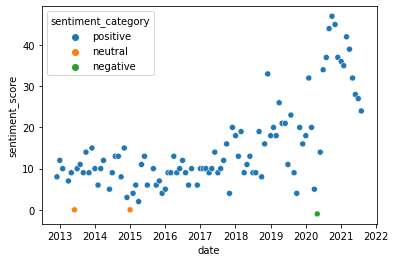

In [ ]:
summary_sentiment_df = caluclate_sentiment_scores_afinn(summary_corpus)
summary_sentiment_df

There is only one negative sentiment score in the entire set. Perhaps the summaries are genereally positive regardess of the business environment.

In [ ]:
# Find a sample of each extreme sentiment score
max_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].max()].index
min_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].min()].index

# Show the most negative sentiment score sample, (first 500 chars)
print(f'Most Negative Summary:')
print(min_sent_idx.date)
pprint(summary_sentiment_df.loc[min_sent_idx,'corpus'].values[0][:500])

Most Negative Summary:
[datetime.date(2020, 5, 1)]
('Production , New Orders , Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Contracting ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Decreasing ; Exports '
 'Imports Contracting Economic activity manufacturing sector contracted April '
 ', overall economy contracted 131 consecutive months expansion , say nations '
 'supply executives latest Manufacturing ISM Report Business. " April PMI '
 'registered 41.5 percent , 7.6 percentage points March reading 49.')


In [ ]:
# Show the most postive sentiment score sample, (first 500 chars)
print(f'Most Positive Summary:')
print(max_sent_idx.date)
pprint(summary_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

Most Positive Summary:
[datetime.date(2020, 10, 1)]
('New Orders Production Growing ; Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Increasing ; Exports '
 'Imports Growing Economic activity manufacturing sector grew September , '
 'overall economy notching fifth consecutive month growth , say nations supply '
 'executives latest Manufacturing ISM Report Business. " September PMI '
 'registered 55.4 percent , 0.6 percentage point August reading 56 perc')


##### WRAS

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Conditions still appear positive continued growth sales. "" Business steady , not much that. lull. "" principle business conditions affect company next three four quarters U.S. federal government ta...",-5.0,negative
2013-01-02,"Many Chinese sources coming us cost reductions maintain current business volumes. "" Saw stronger expected demand October November , December demand weak comparatively. "" seeing stabilization order...",8.0,positive
2013-02-01,"Fiscal cliff , uncertainty general EU economic weakness factors causing customers tentative commitments product purchases 2013. "" Midwest drought impact felt least midyear , impacting protein , sw...",6.0,positive
2013-04-01,"Beginning feel seasonal upswing business energy resin remain concern. "" Medical reimbursements insurance companies , particularly Medicare , slowing. "" second half 2013 looks promising , first hal...",11.0,positive
2013-05-01,"Business described flat best. "" Production still strong ; several new projects support alternative energy. "" Slight uptick business , overall continuing slowdown defense due budget/sequester. "" co...",11.0,positive
...,...,...,...
2021-04-01,"Late-winter storms unexpected [ areas ] U.S. organization exercising business-continuity plans much aggressive scale anticipated. storms slowed supply chain , could meet orders , even though short...",10.0,positive
2021-05-03,"current electronics/semiconductor shortage tremendous impacts lead times pricing. Additionally , appears general inflation prices across , not , supply lines. "" Upstream producers/suppliers back o...",-6.0,negative
2021-06-01,"Supplier performance deliveries , quality , suffering. Demand high , struggling find employees help us keep up. "" Changes currency exchange rates favorably contributed quarterly performance. Conti...",-12.0,negative


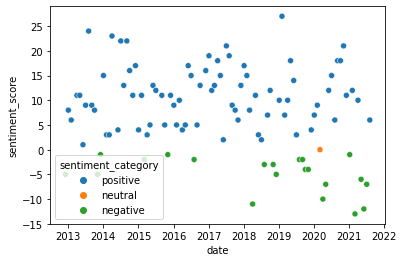

In [ ]:
wras_sentiment_df = caluclate_sentiment_scores_afinn(wras_corpus)
wras_sentiment_df

There is a mixxture of positive and negative sentiment scores, and almost no neutral scores. Perhaps the compilers of the report like to pick  both negative and positive quotes to include in the report (likely manually--not programatically).

In [ ]:
max_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].max()].index
min_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].min()].index

print(min_sent_idx.date)
print(f'Most Negative WRAS:')
pprint(wras_sentiment_df.loc[min_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2021, 3, 1)]
Most Negative WRAS:
('coronavirus [ COVID-19 ] pandemic affecting us terms getting material build '
 'local overseas third- fourth-tier suppliers. Suppliers complaining [ lack ] '
 'available resources [ people ] manufacturing , creating major delivery '
 'issues. " Supply chains depleted ; inventories supply chain empty. Lead '
 'times increasing , prices increasing , [ ] demand increasing. Deep freeze '
 'Gulf Coast expected extend duration shortages. " Steel prices increased '
 'significantly recent months , driving costs suppliers propo')


In [ ]:
# Show the most postive sentiment score sample, (first 500 chars)
print(max_sent_idx.date)
print(f'Most Positive WRAS:')
pprint(wras_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2019, 2, 1)]
Most Positive WRAS:
('Unlike last years , experiencing first quarter slowdown. " Steady supply '
 'production environment. " Concerns oil prices fueling questions strong '
 'economy first half 2019. " Overall , business continues good ; however , '
 'margins squeezed. " federal government shutdown impacting ability get new '
 'products launched. wines need TTB [ Alcohol Tobacco Tax Trade Bureau ] '
 'approval. reforecasting accordingly. " continue enjoy benefits strong '
 'general economy. busy maintain backlog sales orders. " Incoming orde')


#### Using TextBlob lexicon

In [ ]:
type(summary_corpus[1])


str

In [ ]:
from textblob import TextBlob

def calculate_sentiment_scores_textblob(corpus, show_plot=True, return_df=True):
  sentiment_scores_tb = [round(TextBlob(release).sentiment.polarity, 3) for release in corpus]
  sentiment_category_tb = ['positive' if score > 0 
                              else 'negative' if score < 0 
                                  else 'neutral' 
                                      for score in sentiment_scores_tb]

  # Make dataframe
  sentiment_tb_df = pd.DataFrame([corpus, sentiment_scores_tb, sentiment_category_tb]).T
  sentiment_tb_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_tb_df['sentiment_score'] = sentiment_tb_df['sentiment_score'].astype('float')
  sentiment_tb_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_tb_df = sentiment_tb_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_tb_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  if return_df:
    return sentiment_tb_df

#### Summary

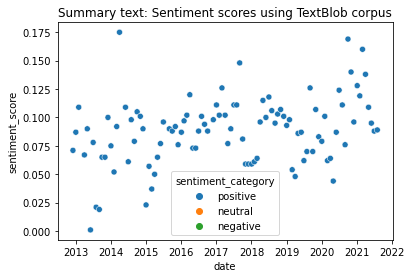

In [ ]:
calculate_sentiment_scores_textblob(summary_corpus, return_df=False)
plt.title('Summary text: Sentiment scores using TextBlob corpus');

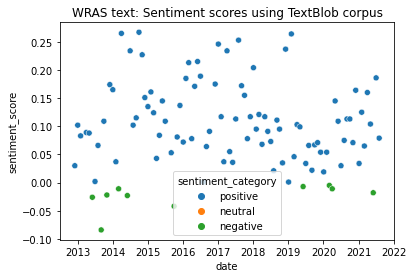

In [ ]:
calculate_sentiment_scores_textblob(wras_corpus, return_df=False)
plt.title('WRAS text: Sentiment scores using TextBlob corpus');

# Feature Engineering & Text Representation

# Count-based Feature Engineering Models

Count-based are effective methods for extracting features from text. However, 
due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence, and context around nearby words in each text document.

## Advantages:
* Easy to understand, implement, and explain.
* Reproducible, and often deterministic
* Low computational cost
* Does not require much training data

## Disadvantages:
* Low performance


In [ ]:
norm_summary_corpus_df = pd.DataFrame(norm_corpus_summary, columns=['document'])
norm_summary_corpus_df.head()

,document
0,economic activity manufacturing sector contract november follow two month modest expansion overall economy grow nd consecutive month say nation supply executive late manufacture ism report busines...
1,economic activity manufacturing sector expand december follow one month contraction overall economy grow rd consecutive month say nation supply executive late manufacture ism report business pmi r...
2,report reflect u department commerces recently complete annual adjustment seasonal factor use calculate index economic activity manufacturing sector expand january second consecutive month overall...
3,economic activity manufacturing sector expand march fourth consecutive month overall economy grow th consecutive month say nation supply executive late manufacture ism report business pmi register...
4,economic activity manufacturing sector expand april fifth consecutive month overall economy grow th consecutive month say nation supply executive late manufacture ism report business pmi register ...


## Bag of Words Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus_summary)
cv_matrix

<101x712 sparse matrix of type '<class 'numpy.int64'>'
	with 12337 stored elements in Compressed Sparse Row format>

In [ ]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix.toarray(), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,activity,add,addition,additionally,address,adequately,adjust,adjusted,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,...,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,us,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
96,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
97,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,6,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
98,0,0,1,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,14,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
99,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
100,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0


## Bag of N-Grams Model

In [ ]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
# 2,2 to get bigrams only
# or 3,3, to get trigrams only
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus_summary)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab).tail()

,abate import,abate say,ability respond,absenteeism short,account overall,achieve year,across country,across entire,across industry,across many,action global,action input,actively evaluate,activity apparel,activity chemical,activity computer,activity continue,activity continued,activity contracting,activity dramatically,activity electrical,activity fabricate,activity food,activity furniture,activity historic,activity include,activity machinery,activity manufacturing,activity miscellaneous,activity nonmetallic,activity paper,activity petroleum,activity plastic,activity primary,activity september,activity textile,activity transportation,activity two,activity wood,add cost,...,well perform,well seventh,well sixth,well supplier,well support,well th,well third,west coast,whether government,whole learn,wide scale,winter high,wood product,work action,work june,work late,work survey,workaround add,worker absenteeism,worker cause,worker continue,worker remain,would consume,year among,year cap,year comment,year continue,year forward,year high,year increase,year indicate,year lead,year manufacturing,year new,year percentage,year positive,year say,year six,zero expansion,zero price
96,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## TF-IDF Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., 
                     max_df=0.99, # Discard words that appear in 99% of the documents
                     norm='l2',
                     use_idf=True, 
                     smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus_summary)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,add,addition,additionally,address,adequately,adjust,adjusted,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,aprils,...,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,us,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
96,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.0
97,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.07,0.0,0.0,0.06,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.18,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
98,0.0,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.06,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.42,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
99,0.0,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
100,0.0,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.06,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0


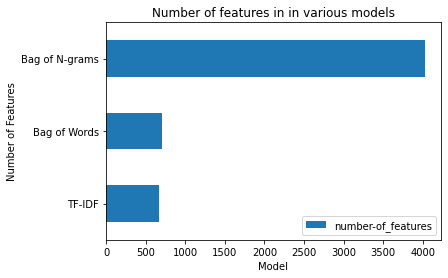

In [ ]:
models_df = pd.Series([cv_matrix.shape[1], bv_matrix.shape[1], tv_matrix.shape[1]], 
                      index=['Bag of Words', 'Bag of N-grams', 'TF-IDF'], 
                      name='number-of_features').sort_values().to_frame()
models_df.plot(kind='barh')
plt.title('Number of features in in various models')
plt.ylabel('Number of Features')
plt.xlabel('Model');

We can see that there's about 5 times more features in the bag of n-grams model compared to the bag- of words model. TF-IDF has slightly fewer features than Bag of Words because we set teh TFIDF Vectorizer to drop words that occur in more than 99% of the documents.

## Document Similarity

Using the output of the TF-IDF Vectorizer, compare the similarity of the adjacent documents.

### Cosine Similarity

cosine_similarity is (1 - cosine_distance).

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

cos_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='cosine')
cos_similarity_df = pd.DataFrame(cos_similarity_matrix)
cos_similarity_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
96,0.130602,0.108352,0.094327,0.504551,0.186793,0.135584,0.143464,0.115476,0.121585,0.146184,0.074645,0.105312,0.103171,0.080198,0.393523,0.448384,0.145739,0.104337,0.113612,0.161717,0.144226,0.131006,0.119976,0.113272,0.107860,0.320802,0.481305,0.260009,0.181349,0.125744,0.144377,0.106280,0.142250,0.093627,0.103823,0.111192,0.324187,0.553338,0.266782,0.127879,...,0.485799,0.386778,0.386347,0.376742,0.368180,0.336071,0.337476,0.335248,0.245264,0.300461,0.435291,0.567958,0.427445,0.321565,0.319613,0.298130,0.287565,0.275746,0.278650,0.279041,0.254295,0.256873,0.424102,0.565884,0.412782,0.360931,0.309732,0.391048,0.418757,0.397734,0.418319,0.438063,0.456645,0.446251,0.604424,1.000000,0.767328,0.624339,0.601013,0.560019
97,0.146344,0.110259,0.091793,0.404861,0.342367,0.188057,0.138658,0.110525,0.121559,0.127251,0.068347,0.105363,0.099232,0.094420,0.111335,0.333009,0.207696,0.127283,0.115158,0.199715,0.159397,0.128725,0.126158,0.121192,0.123139,0.120209,0.287354,0.521199,0.248783,0.119310,0.159732,0.115352,0.140290,0.099274,0.104088,0.093500,0.122752,0.376297,0.526652,0.212619,...,0.677148,0.464076,0.393558,0.406598,0.377391,0.347540,0.369306,0.351853,0.292013,0.320892,0.338375,0.410799,0.572588,0.403675,0.323520,0.341587,0.324663,0.300143,0.284312,0.285700,0.270122,0.248298,0.305881,0.435812,0.568188,0.427064,0.333309,0.411562,0.432337,0.414643,0.421296,0.457382,0.482718,0.483934,0.510882,0.767328,1.000000,0.731857,0.643927,0.611250
98,0.135571,0.113085,0.102056,0.132032,0.291051,0.326406,0.223020,0.121774,0.131960,0.139388,0.072522,0.146161,0.128585,0.083998,0.111023,0.137120,0.398871,0.286809,0.117846,0.185645,0.159843,0.136487,0.113444,0.110644,0.119178,0.106691,0.116954,0.283085,0.445497,0.237513,0.140169,0.105247,0.145507,0.093603,0.100550,0.095061,0.121016,0.132912,0.307490,0.486568,...,0.567695,0.684920,0.539517,0.437204,0.422035,0.372074,0.424411,0.364683,0.289014,0.346812,0.343913,0.321842,0.404307,0.561340,0.424378,0.346984,0.321538,0.292488,0.295638,0.300924,0.288905,0.263347,0.314569,0.288887,0.412407,0.592414,0.419609,0.431499,0.440085,0.422271,0.456634,0.473810,0.497991,0.506448,0.532856,0.624339,0.731857,1.000000,0.814084,0.674614
99,0.168274,0.112220,0.095556,0.122475,0.139736,0.346984,0.387641,0.179671,0.150052,0.146334,0.086558,0.137223,0.123573,0.085193,0.107205,0.135913,0.369143,0.502466,0.238807,0.174487,0.166542,0.135730,0.116937,0.116876,0.117777,0.114626,0.141750,0.105362,0.345198,0.433472,0.179943,0.113879,0.154866,0.099629,0.111056,0.099577,0.129693,0.131351,0.118080,0.409543,...,0.454549,0.568925,0.711935,0.532216,0.448376,0.386987,0.404580,0.375612,0.310725,0.347536,0.346131,0.325716,0.321738,0.485328,0.564875,0.415133,0.340229,0.298857,0.279100,0.284520,0.295083,0.249539,0.289463,0.270033,0.318967,0.489756,0.523016,0.499829,0.442635,0.404191,0.433420,0.457000,0.481166,0.487637,0.523599,0.601013,0.643927,0.814084,1.000000,0.774855
100,0.191308,0.130235,0.099089,0.133244,0.151678,0.253268,0.364020,0.319515,0.218204,0.153099,0.110873,0.140226,0.145323,0.095184,0.120050,0.132790,0.157345,0.357158,0.461341,0.286013,0.187191,0.145652,0.132876,0.121797,0.124144,0.121200,0.141941,0.104870,0.169022,0.257750,0.294386,0.121910,0.139854,0.112503,0.113891,0.098557,0.126360,0.122956,0.114443,0.138803,...,0.419385,0.420427,0.547827,0.682513,0.510353,0.397725,0.393174,0.354342,0.339063,0.355066,0.351685,0.333304,0.353896,0.373666,0.473928,0.583456,0.415682,0.316266,0.325328,0.320037,0.324111,0.261585,0.319155,0.299083,0.331850,0.395350,0.446983,0.683122,0.520546,0.416362,0.430231,0.465569,0.458396,0.452273,0.489204,0.560019,0.611250,0.674614,0.774855,1.000000


### [Jaccard Similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)

Jaccard_similarity is (1 - Jaccard_distance).

In [ ]:
from sklearn.metrics import pairwise_distances

jac_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='jaccard')
jac_similarity_df = pd.DataFrame(jac_similarity_matrix)
jac_similarity_df.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
96,0.204301,0.197917,0.184358,0.250000,0.225434,0.212644,0.209302,0.211765,0.183432,0.213018,0.188889,0.180233,0.170455,0.193548,0.218935,0.215116,0.215569,0.225610,0.207101,0.234286,0.229412,0.210843,0.244048,0.213873,0.202186,0.224852,0.238889,0.209581,0.264368,0.196629,0.232143,0.222892,0.223529,0.197605,0.206061,0.225989,0.215569,0.220859,0.173913,0.231250,...,0.357542,0.346154,0.338710,0.349727,0.355330,0.350254,0.347826,0.357895,0.304813,0.288660,0.315217,0.312821,0.329787,0.324742,0.314433,0.325000,0.336634,0.352632,0.354167,0.357513,0.344498,0.305825,0.347368,0.346154,0.372549,0.365741,0.354839,0.404040,0.429825,0.429245,0.477612,0.545894,0.556650,0.543269,0.637838,1.000000,0.833333,0.680851,0.663043,0.627551
97,0.196891,0.190955,0.183784,0.218391,0.237288,0.204420,0.214689,0.203390,0.189655,0.204545,0.188172,0.186441,0.170330,0.205263,0.203390,0.213483,0.206897,0.230769,0.212644,0.238889,0.227273,0.209302,0.220339,0.205556,0.213904,0.215909,0.236559,0.208092,0.233696,0.182796,0.222857,0.213873,0.214689,0.182857,0.204678,0.210811,0.228070,0.197674,0.180723,0.221557,...,0.351351,0.333333,0.319588,0.343915,0.336585,0.325243,0.328125,0.338384,0.307292,0.278607,0.296875,0.295567,0.311224,0.313433,0.316583,0.333333,0.338164,0.360825,0.348485,0.345000,0.352113,0.295775,0.341837,0.316514,0.353774,0.348214,0.361991,0.390244,0.405063,0.428571,0.447619,0.528037,0.530806,0.532710,0.597938,0.833333,1.000000,0.708995,0.691892,0.663265
98,0.175258,0.181818,0.173913,0.194286,0.206704,0.194444,0.204545,0.193182,0.200000,0.194286,0.172043,0.176136,0.153846,0.183246,0.186441,0.196629,0.196532,0.227545,0.195402,0.215470,0.210227,0.191860,0.196629,0.202247,0.217391,0.185393,0.194737,0.190751,0.217391,0.192308,0.198864,0.196532,0.197740,0.165714,0.180233,0.194595,0.196532,0.180233,0.176829,0.210843,...,0.342391,0.353261,0.352941,0.335106,0.334975,0.317073,0.340426,0.329949,0.305263,0.295918,0.301587,0.274510,0.302564,0.318182,0.314721,0.318627,0.317308,0.331633,0.340102,0.357143,0.344340,0.306220,0.361257,0.308756,0.358852,0.346847,0.354545,0.382353,0.386555,0.427907,0.475490,0.506977,0.531100,0.504630,0.598958,0.680851,0.708995,1.000000,0.791908,0.700000
99,0.211111,0.197861,0.177143,0.198795,0.218935,0.227545,0.231707,0.219512,0.220126,0.206061,0.188571,0.193939,0.176471,0.193370,0.190476,0.208333,0.216049,0.250000,0.229814,0.242604,0.222892,0.203704,0.208333,0.214286,0.215909,0.196429,0.212291,0.202454,0.236994,0.203488,0.218182,0.208589,0.209581,0.182927,0.198758,0.205714,0.216049,0.191358,0.188312,0.224359,...,0.369942,0.381503,0.380682,0.369318,0.352332,0.340206,0.351955,0.340426,0.322222,0.311828,0.311111,0.282051,0.318919,0.342246,0.345946,0.356021,0.340102,0.356757,0.343915,0.361702,0.361386,0.315000,0.344086,0.286385,0.349754,0.344186,0.364929,0.380711,0.385281,0.414286,0.440594,0.495238,0.497585,0.485849,0.588235,0.663043,0.691892,0.791908,1.000000,0.809249
100,0.222222,0.221649,0.190217,0.211429,0.230337,0.245714,0.242775,0.224138,0.210526,0.225434,0.201087,0.200000,0.189944,0.205263,0.210227,0.213483,0.213873,0.245509,0.226744,0.274286,0.241379,0.223529,0.227273,0.205556,0.213904,0.209040,0.223404,0.208092,0.233696,0.189189,0.229885,0.213873,0.214689,0.196532,0.204678,0.210811,0.220930,0.197674,0.173653,0.228916,...,0.358696,0.354839,0.354497,0.372973,0.390863,0.371859,0.363636,0.338384,0.342246,0.324742,0.324468,0.321608,0.345550,0.340102,0.350515,0.373737,0.351220,0.360825,0.376289,0.386598,0.391304,0.320574,0.348718,0.316514,0.353774,0.378995,0.400000,0.410891,0.393305,0.422018,0.468599,0.506912,0.502326,0.477477,0.581633,0.627551,0.663265,0.700000,0.809249,1.000000


In [ ]:
# Check the correlation of the two methods of calculating simlilarity
jac_similarity_df.corrwith(cos_similarity_df).mean()

0.564629994665854

## Clustering documents using similarity features

### Using Cosine Similarity

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_cos = linkage(cos_similarity_matrix, 'ward')
# pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()

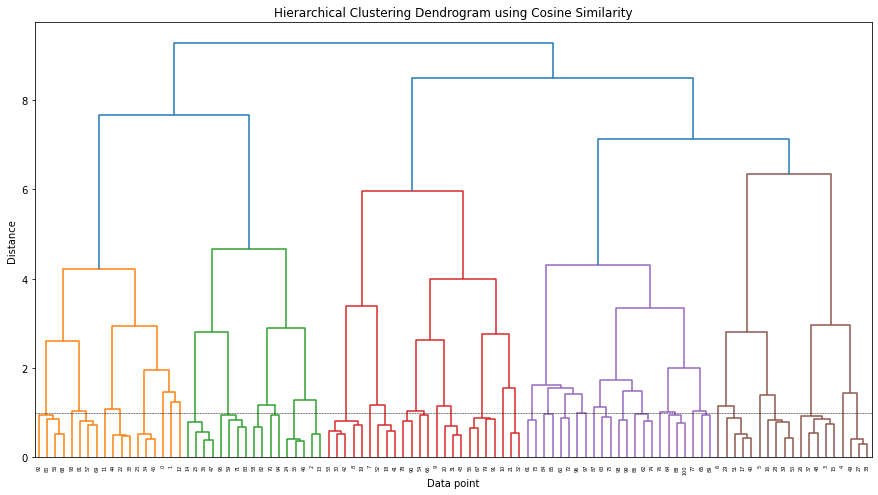

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Cosine Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_cos)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 0.5

cluster_labels_cos = fcluster(Z_cos, max_dist, criterion='distance')
cluster_labels_cos = pd.Series(cluster_labels_cos, name='cluster_label_using_cosine_similarity')
# cluster_labels_cos.value_counts()

### Using Jaccard Similarity

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_jac = linkage(jac_similarity_matrix, 'ward')
# pd.DataFrame(Z_jac, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()



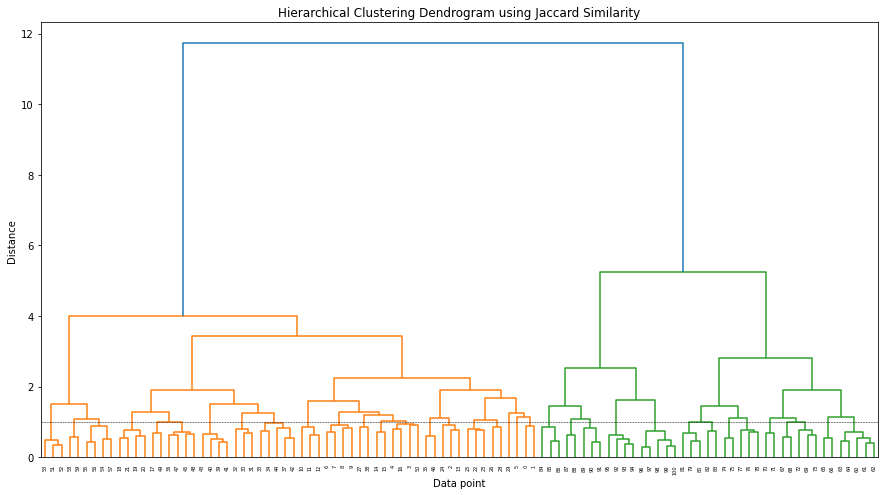

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Jaccard Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_jac)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels_jac = fcluster(Z_jac, max_dist, criterion='distance')
cluster_labels_jac = pd.Series(cluster_labels_jac, name='cluster_label_using_jaccard_similarity')
# cluster_labels_jac.value_counts()

## Topic Models

In [ ]:
n_components = 5
n_top_words = 20
max_iter = 1000

### Using [NMF](https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf)

>The time complexity is polynomial in NMF.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=n_components,
          beta_loss='kullback-leibler', 
          solver='mu', 
          max_iter=max_iter, 
          alpha=.1,
          l1_ratio=.5)
dt_matrix_nmf = nmf.fit_transform(tv_matrix)
features_nmf = pd.DataFrame(dt_matrix_nmf, columns=[f'Topic_{i}' for i in range(n_components)])
features_nmf.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
96,0.364479,3.883094e-13,0.0,0.129554,0.00000
97,0.405285,2.180685e-24,0.0,0.070385,0.00000
98,0.432396,0.000000e+00,0.0,0.000000,0.00000
99,0.411511,0.000000e+00,0.0,0.000000,0.00000
100,0.398355,0.000000e+00,0.0,0.000000,0.08669


In [ ]:
# Show topics and their weights
tt_matrix_nmf = nmf.components_
for topic_weights in tt_matrix_nmf:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.5]
    print(topic)
    print()

[('inventory', 0.6169379352414519), ('supplier', 0.5368685155264288), ('continue', 0.5328783047395921), ('april', 0.520220877371705)]

[('january', 1.1284300378363208), ('december', 0.6235424393294586)]

[('november', 0.8538707550471487), ('october', 0.7942419893230492)]

[('august', 0.8406350564088889), ('march', 0.7713809852923715), ('february', 0.6655744756674934)]

[('july', 0.8374880474704259), ('june', 0.8240132454786624), ('may', 0.7484746439218632)]



### Using [LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

>In LDA, the time complexity is proportional to (n_samples * iterations).

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n_components, max_iter=max_iter)
dt_matrix_lda = lda.fit_transform(tv_matrix)
features_lda = pd.DataFrame(dt_matrix_lda, columns=[f'Topic_{i}' for i in range(n_components)])
features_lda

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,0.025554,0.024512,0.900913,0.024512,0.024509
1,0.196296,0.024439,0.729122,0.024439,0.025704
2,0.051463,0.029196,0.453444,0.029196,0.436701
3,0.034998,0.033014,0.865965,0.033014,0.033009
4,0.029486,0.028176,0.885989,0.028176,0.028173
...,...,...,...,...,...
96,0.925026,0.018658,0.019002,0.018658,0.018656
97,0.927686,0.018009,0.018291,0.018009,0.018005
98,0.927523,0.018057,0.018307,0.018057,0.018057
99,0.924148,0.018883,0.019205,0.018883,0.018880


In [ ]:
# Show topics and their weights
tt_matrix_lda = lda.components_
for topic_weights in tt_matrix_lda:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.3]
    print(topic)
    print()

[('supplier', 8.259994672587196), ('reading', 8.028243607179824), ('continue', 7.622725854338754), ('inventory', 7.367904934831023), ('delivery', 6.901830256812592), ('increase', 5.054970023403921), ('import', 4.904655701324091), ('decrease', 4.720288800938182), ('level', 4.539162081173317), ('compare', 4.512061864485237), ('price', 4.404555858222329), ('rate', 4.311735887832624), ('backlog', 4.288653735440655), ('slow', 4.102185145741637), ('low', 4.029395610079015), ('expand', 3.9373215538964783), ('contract', 3.902223561211348), ('remain', 3.86493232712907), ('customer', 3.7725495143300884), ('export', 3.6873657796254236), ('september', 3.6264525040807025), ('october', 3.6262370048693313), ('november', 3.553075000971633), ('employment', 3.551900304506686), ('january', 3.5420375262765966), ('input', 3.5001351145500514), ('april', 3.38568372912315), ('expansion', 3.3314390299827457), ('february', 3.292214752705069), ('may', 3.2628252771689095), ('march', 3.2320852410052994), ('june', 

In [ ]:
# Check the correlations of NMF and LDA topic models
pd.DataFrame(tt_matrix_nmf).corrwith(pd.DataFrame(tt_matrix_lda)).mean()

0.4923981118093393

The correlation shows that the NMF and LDA produce mostly uncorrelated output.

### Clustering documents using topic model features

Let's compares the labels assigned by a Kmeans model of the topics for NMF and LDA

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_nmf)
cluster_labels_nmf = km.labels_
cluster_labels_nmf = pd.Series(cluster_labels_nmf, name='topic_labels_NMF', index=dates_ser)

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_lda)
cluster_labels_lda = km.labels_
cluster_labels_lda = pd.Series(cluster_labels_lda, name='topic_labels_LDA', index=dates_ser)

# summary_df.join((cluster_labels_nmf, cluster_labels_lda))[['topic_labels_NMF','topic_labels_LDA', 'summary']]

# Check the correlation of cluster labels from NMF vs LDA 
cluster_labels_lda.corr(cluster_labels_nmf)

-0.34578503268168403

We see that the two methods of cluster labels are also create uncorrelated output.

# Context-based Feature Engineering Models

Traditional models have some limitations considering sparse representations,
leading to feature explosion and the curse of dimensionality. This is in addition to the already mentioned loss of context, ordering, and sequence of related words in text data.

Advanced feature engineering models, which use deep learning and neural network models generate dense embeddings for every word in any corpus, while retaining the context, ordering, and sequence of related words.

## Advantages:
* High performance
* High computational cost
* Requires large mounts of training data

## Disadvantages:
* Difficult to understand, implement, and explain.
* Not deterministic (uses random parameters upon initialization)

## Word2Vec

Let's use the GenSim implementation of Word2Vec, which is optimized for large corpora.

Input: a corpus of documents
Output: feature vectors

Steps: 
1. tokenize our normalized corpus
2. tune the following four parameters in the Word2Vec model to build it. 

Parameters:
* `vector_size`: the dimension for the word vectors. Useful range: 10's to thousands. 
* `window`: the length of the window of words that should be considered for the algorithm to take into account as context when training. Useful range: probably range(0-100). 
* `min_count`: This parameter specifies the minimum word count needed across the corpus for the word to be considered in the vocabulary. This helps remove very specific words that may not have much significance since they occur very rarely in the documents.
* `sample`: This parameter is used to downsample effects of occurrence of frequent words. Useful range: between 0.01 and 0.0001.

For each parameter: Pick the one that performs best in cross-validation.

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
vector_size = 20    # Word vector dimensionality  
window = 20         # Context window size                                                                                    
min_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=vector_size, 
                          window=window, min_count=min_count,
                          sample=sample, epochs=200)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['grow', 'contract', 'month', 'slow', 'fast', 'delivery', 'customer', 'furniture', 'electronic']}

print("similar words based on gensim's word2vec model, where key is the word")
print('and the values are the top 5 words appearing in the context of the key word')
similar_words



/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


similar words based on gensim's word2vec model, where key is the word
and the values are the top 5 words appearing in the context of the key word


{'contract': ['grow', 'rate', 'economic', 'sector', 'uncertain'],
 'customer': ['contracting', 'rate', 'expand', 'soften', 'grow'],
 'delivery': ['inventory', 'despite', 'offset', 'partially', 'plant'],
 'electronic': ['chemical', 'paper', 'four', 'tobacco', 'industry'],
 'fast': ['slow', 'contracting', 'low', 'unchanged', 'grow'],
 'furniture': ['electrical', 'chemical', 'wood', 'paper', 'default'],
 'grow': ['contract', 'notch', 'rate', 'slow', 'fast'],
 'month': ['read', 'fourth', 'consecutive', 'since', 'third'],
 'slow': ['fast', 'unchanged', 'notch', 'contracting', 'grow']}

The sample output here makes sense.

### Build framework for getting document level embeddings

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=vector_size)
pd.DataFrame(w2v_feature_array).tail(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100,-0.213066,-0.822861,0.704561,-0.699276,0.783567,-0.37036,-0.786043,0.80633,-0.668383,-0.013945,0.065067,1.054111,-0.606093,-0.699984,2.536171,0.752956,-0.23289,0.507324,-0.925715,-0.839031


### Clustering with word embeddings

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(random_state=None)
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.Series(cluster_labels, name='w2v_cluster_label')
# pd.concat([summary_df.reset_index(), cluster_labels], axis=1)[['clean_summary', 'w2v_cluster_label']].tail()

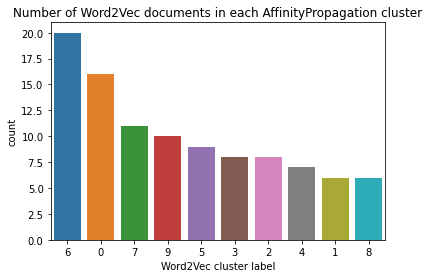

In [ ]:
g = sns.countplot(x=cluster_labels, order=cluster_labels.value_counts().index)
g.set(title='Number of Word2Vec documents in each AffinityPropagation cluster',
      xlabel='Word2Vec cluster label');

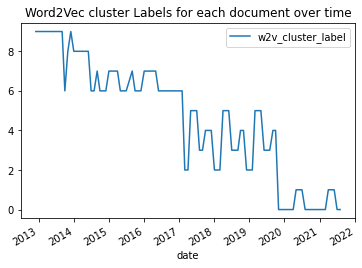

In [ ]:
pd.DataFrame(cluster_labels).set_index(dates_ser).plot()
plt.title('Word2Vec cluster Labels for each document over time');

The cluster labels tends to stay the same for consecutive months (high autocorrelation). This makes sense, as the words in the documents should be similar for similar dates as the topics written in the monthly news releases are not expected to be very different each month.

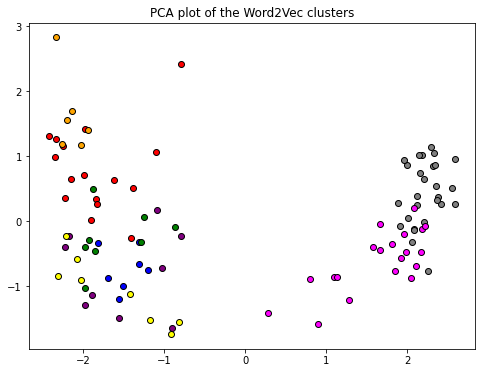

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
# categories = list(summary_corpus_df['Category'])
plt.figure(figsize=(8, 6))
plt.title('PCA plot of the Word2Vec clusters')
colors_dict = {0: 'red', 1: 'orange', 2:'yellow', 3:'green', 4:'blue', 5:'purple', 6:'magenta'}

for i in range(len(labels)):
  label = labels[i]
  # color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
  color = colors_dict[label] if label in colors_dict.keys() else 'grey'
  # annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')
  # plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe (Global Vectors)

Let's use the Spacy implementation of GloVe.



## Visualize GloVe word embeddings


In [ ]:
nlp = spacy.load('en_core_web_md')
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus_summary] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
weight,-0.63463,1.48400,-0.024017,0.746960,-0.832190,0.386440,-0.321560,-0.46269,-0.304310,1.3228,-0.409030,0.091630,-0.250070,0.436670,0.140510,-0.65658,0.148520,2.4582,-0.322530,0.17370,-0.47777,-0.381100,-0.393090,-0.47779,-0.44001,-0.002721,0.075472,-0.202120,-0.256140,-0.448050,-0.23059,0.018169,-0.166660,-0.21889,0.587130,0.010487,0.24120,0.025306,-0.331790,0.23345,...,-0.168840,-0.358730,-0.036699,0.16511,0.076435,0.21227,0.224830,0.136790,-0.15957,-0.155960,0.588160,-0.30089,-0.306090,-0.134520,0.21400,-0.335930,0.477050,0.609100,-0.151460,0.051931,-0.527280,0.191950,0.425880,0.127790,-0.369740,0.533520,-0.955620,-0.078860,0.63021,0.161360,0.70168,-0.168820,0.140330,-0.303600,-0.367720,0.26387,0.11932,-0.183660,0.204940,0.087171
equal,-0.18328,0.36197,0.126770,-0.077392,0.060114,-0.353560,-0.222990,0.44480,0.048293,1.8573,0.163720,0.295230,-0.429020,0.275230,0.046343,0.13552,-0.253390,1.4494,-0.391060,0.29233,-0.28909,-0.109860,-0.057522,-0.20882,0.20313,-0.692720,0.180830,-0.094436,0.023017,0.261650,-0.10723,0.251130,0.079623,0.37652,0.306710,-0.408500,-0.30793,-0.114810,0.021949,-0.13892,...,-0.258130,-0.039775,-0.423650,0.39801,-0.178420,0.10316,0.347820,-0.043396,0.60138,-0.157400,0.365980,-0.17432,-0.146830,-0.090401,-0.35842,-0.217870,-0.099178,-0.013533,0.047795,0.518090,0.006404,0.438460,0.019954,-0.007324,-0.243130,0.153270,0.083863,-0.349330,0.22147,0.400520,0.11537,-0.043631,-0.200810,-0.322040,-0.293450,0.26400,-0.25825,-0.672240,0.182190,-0.013011
growth,-0.78077,0.92675,-0.162410,-0.449910,0.210610,-0.170680,0.404850,0.71640,0.438280,2.5489,-0.774930,0.074758,-0.020398,0.741100,0.707710,0.34354,0.388210,2.0663,-0.012037,0.49392,0.03474,0.628750,-0.127390,-0.17175,-0.25143,0.222380,-0.446960,0.692240,0.079702,0.216530,-0.64470,0.076916,-0.029739,-0.52379,0.407650,0.549690,0.33176,0.107760,0.101320,-0.14770,...,0.167190,0.553410,-0.271910,0.43069,0.245780,-0.45095,-0.093945,-0.243370,0.55396,0.116190,0.017537,-0.02860,0.204650,-0.414040,-0.18790,-0.196250,-0.470380,-0.148100,0.078583,0.541360,-0.586820,-0.099033,-0.357990,0.545110,0.017425,-0.061853,0.246430,-0.378500,0.16639,-0.152570,-0.33285,0.295650,0.232550,-0.368940,-0.208990,0.38321,-0.41237,-0.016264,0.212260,-0.090905
indication,0.19357,0.30612,0.108990,0.156870,-0.101950,-0.350220,-0.064109,-0.15652,0.061438,1.7533,0.258840,0.106630,0.093242,0.067266,0.016859,-0.25505,0.056624,1.5306,0.113220,-0.18379,-0.16882,-0.095255,-0.304980,-0.23072,0.20588,0.217560,0.081152,-0.117220,-0.008829,-0.164820,0.26164,0.080597,0.089587,-0.02872,-0.355460,0.629820,-0.39985,0.037968,0.148680,-0.13249,...,-0.169630,-0.496180,-0.229690,0.12556,0.246000,0.20191,0.434790,0.055359,0.96206,-0.236100,0.246140,0.62665,-0.052034,-0.009055,0.05914,0.021261,0.118870,0.189620,0.019267,0.274500,-0.128530,-0.131880,0.388000,0.039294,-0.267830,0.352570,-0.409350,0.163280,0.23763,0.093557,-0.19637,0.377260,-0.344060,0.157780,0.298940,-0.17484,-0.36186,-0.027055,-0.161360,-0.009574
downside,-0.36009,0.12898,-0.062019,0.187880,-0.303720,0.031988,-0.277690,-0.27593,0.304830,1.1383,0.042317,-0.117260,0.180040,0.332140,0.138340,-0.19060,-0.184140,0.8138,-0.060869,0.30132,-0.64799,0.178400,0.213810,-0.18923,-0.12680,0.324880,-0.041045,0.000483,-0.440970,0.055454,0.15075,0.136750,0.181140,-0.26082,-0.041886,0.452250,0.30487,0.290110,0.394940,-0.41407,...,-0.097558,0.081831,-0.152650,0.17172,-0.106210,0.08034,0.069838,0.072981,0.40668,-0.059102,-0.238970,-0.16603,0.041953,-0.254180,-0.15374,0.106900,-0.135800,-0.227620,-0.101540,0.219230,-0.071237,-0.303450,-0.168210,0.267210,0.380470,0.160110,-0.443360,0.003025,-0.21453,0.246550,-0.34941,0.627180,-0.013817,-0.080353,-0.018115,0.46634,-0.17329,-0.457450,0.046083,0.06241

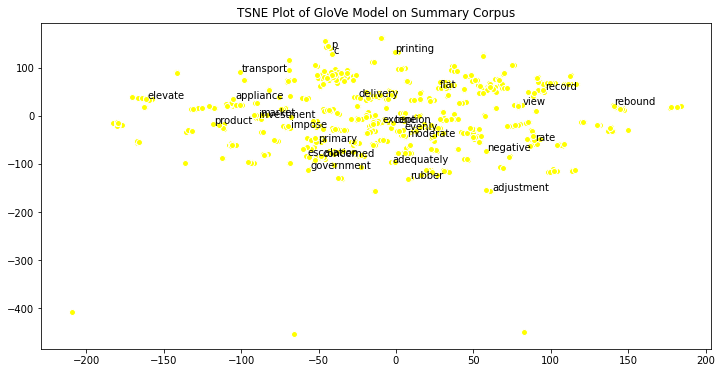

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='yellow', edgecolors='white')
skip_counter = 0
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  # annotate a small fraction of the plot
  if skip_counter == 24:
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    skip_counter=0
  else:
    skip_counter += 1
plt.title('TSNE Plot of GloVe Model on Summary Corpus');

There's no obvious pattern from the text annotations in the TSNE plot, but we can see  various small clusters and some  large clusters.

## FastText

In [ ]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
vector_size = 100    # Word vector dimensionality  
window = 50          # Context window size                                                                                    
min_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(sentences=tokenized_corpus, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=min_count,
                    sample=sample, 
                    sg=1, 
                    epochs=50)

# view similar words based on gensim's fasttext model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['grow', 'contract', 'month', 'slow', 'fast', 'delivery', 'customer', 'furniture', 'electronic']}

print("similar words based on gensim's fasttext model, where key is the word")
print('and the values are the top 5 words appearing in the context of the key word')
similar_words

similar words based on gensim's fasttext model, where key is the word
and the values are the top 5 words appearing in the context of the key word


{'contract': ['contracting', 'inventory', 'import', 'delivery', 'rate'],
 'customer': ['inventory', 'low', 'backlog', 'export', 'production'],
 'delivery': ['supplier', 'inventory', 'import', 'contract', 'supply'],
 'electronic': ['equipment', 'metal', 'product', 'petroleum', 'fabricate'],
 'fast': ['slow', 'rate', 'inventory', 'contract', 'contracting'],
 'furniture': ['related', 'nonmetallic', 'paper', 'mineral', 'rubber'],
 'grow': ['increase', 'executive', 'ism', 'manufacture', 'economy'],
 'month': ['consecutive', 'production', 'index', 'inventory', 'indicate'],
 'slow': ['inventory', 'rate', 'fast', 'grow', 'contract']}

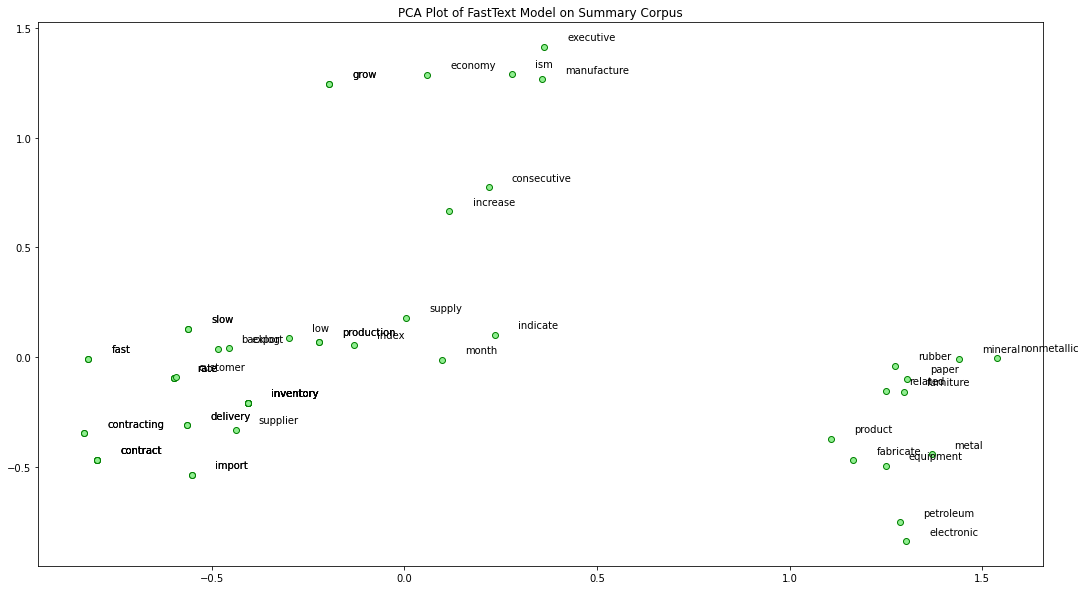

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')
plt.title('PCA Plot of FastText Model on Summary Corpus');

# Supervised Learning Models for Text Data


* (Multinomial) Naïve Bayes
* Logistic regression
* Support vector machines
* Random forest
* Gradient boosting machine

### Check the preprocessing before modeling

In [ ]:
# Check dataframe
df.head(1)

,summary,wras,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_in_short_supply,commodities_short_count,gdp_growth_direction,clean_summary,clean_wras
date,,,,,,,,,,,
2012-12-03,"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's suppl...","Conditions still appear to be positive for continued growth in sales."" Business is steady, but not much more than that. We are in a lull."" The principle business conditions that will affect the co...","Aluminum Products, Caustic Soda, Corrugated Boxes/Packaging, Polypropylene, Propylene, Steel, Steel – Hot Rolled",7,"Fuel, Oil, Steel",3,None,1,0.0,economic activity manufacturing sector contract november follow two month modest expansion overall economy grow nd consecutive month say nation supply executive late manufacture ism report busines...,condition still appear positive continued growth sale business steady not much lull principle business condition affect company next three four quarter u federal government tax budgetary policy im...


Check the distribution of the classes

In [ ]:
from sklearn.model_selection import train_test_split

X = df.dropna()['clean_summary']
y = df.dropna()['gdp_growth_direction'].astype(int)

(train_corpus, test_corpus, 
   train_labels, test_labels) = train_test_split(X, y, test_size=0.25)

train_corpus.shape, test_corpus.shape

((72,), (25,))

In [ ]:
# Check the size of the classes
from collections import Counter

trd = dict(Counter(train_labels))
tsd = dict(Counter(test_labels))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd], 
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
0,0,40,11
1,1,32,14


The classes appear to be fairly unbalanced. There's about 10-20% more items in the '0 class, relative to the '1' class.

Check the Vectorizing of the tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

## CountVectorizer
# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(train_corpus)

# transform test articles into features
cv_test_features = cv.transform(test_corpus)

## TfidfVectorizer
# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

# transform test articles into features
tv_test_features = tv.transform(test_corpus)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (72, 638)  Test features shape: (25, 638)
TFIDF model:> Train features shape: (72, 638)  Test features shape: (25, 638)


In [ ]:
def plot_cv_results(cv_results, param_x: str, param_z: str, metric: str ='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    if type(cv_results)==dict:
      cv_results = pd.DataFrame(cv_results)
    elif type(cv_results)==str:
      with open(working_path/f'cv_results/{model_name}.pkl.gzip', 'wb') as f:
        cv_results = pd.read_pickle(f)
        assert isinstance(cv_results, pd.DataFrame)
    else:
      assert isinstance(cv_results, pd.DataFrame)

    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, 
                  hue=col_z, 
                  data=cv_results, 
                  dodge=True, 
                  ci=99, 
                  n_boot=64, 
                  ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return ax

def make_gscv_results_plot_asof_dates(cv_results):
  stats = cv_results.groupby(['asof_date'])['mean_test_score'].agg(['mean', 'count', 'std'])

  ci95_hi = []
  ci95_lo = []

  for i in stats.index:
      m, c, s = stats.loc[i]
      ci95_hi.append(m + 1.95*s/np.sqrt(c))
      ci95_lo.append(m - 1.95*s/np.sqrt(c))

  stats['ci95_hi'] = ci95_hi
  stats['ci95_lo'] = ci95_lo
  fig, ax = plt.subplots()
  stats['mean'].plot(ax=ax)
  ax.fill_between(stats['ci95_hi'].index, stats['ci95_hi'], stats['ci95_lo'],  alpha=0.1)
  ax.set_title('Grid_search cross-val score on data as-of various dates')
  ax.set_ylabel('Accuracy')
  
def plot_confusion_matrix(true, preds, *args, **kwargs):
  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(true, preds)

  def make_confusion_matrix(cf,
                                group_names=[None],
                                categories='auto',
                                count=True,
                                percent=True,
                                cbar=True,
                                xyticks=True,
                                xyplotlabels=True,
                                sum_stats=True,
                                figsize=None,
                                cmap='Blues',
                                title=None,
                                ax=None, *args, **kwargs):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                  Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  
    title:         Title for the heatmap. Default is None.
    '''
    ax = kwargs.get('ax', plt.gca())

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax=ax)

    if xyplotlabels:
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label' + stats_text)
    else:
        ax.set_xlabel(stats_text)
    
    if title:
        ax.set_title(title)
  
  make_confusion_matrix(cm, cbar=False)

def plot_forecasts(pred, suptitle):
  # true = df['gdp_growth_direction']
  # true = pred.to_frame().join(true).drop(columns=['pred'])
  # forecast_df = pd.DataFrame({'true':true, 
  #                                 'pred':pred})
  if isinstance(pred, pd.Series):
    temp = pred.rename('pred').to_frame()
    temp['true'] = df['gdp_growth_direction'][pred.index]

  else:
    temp = pred
  fig, ax = plt.subplots(1, 2, figsize=(12,6))
  temp.plot(ax=ax[0])
  plot_confusion_matrix(temp['true'], temp['pred'], ax=ax[1])
  fig.suptitle(suptitle)
  # plt.tight_layout()
  plt.show()

Split data with time-series split to do a walk-forward analysis during the grid search.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Using time series split
# Make Grid Search splits
n_splits = int(0.2*len(train_labels))
gs_splits = TimeSeriesSplit(n_splits=n_splits, test_size=2)

X_gs = df.dropna().drop(columns='gdp_growth_direction').iloc[:-n_splits]
y_gs = df.dropna()['gdp_growth_direction'].iloc[:-n_splits]

# Make forecast splits
X = df.dropna().drop(columns='gdp_growth_direction')
y = df.dropna()['gdp_growth_direction'].astype(int)
forecast_splits = TimeSeriesSplit(n_splits=len(test_corpus),
                                  test_size=1)


In [ ]:
# Make custom transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.preprocessing import MultiLabelBinarizer

# Cache reused transformers
from tempfile import mkdtemp
from shutil import rmtree

cachedir = mkdtemp()
# Clear the cache directory when you don't need it anymore
# rmtree(cachedir)

# diplays HTML representation in a jupyter context
from sklearn import set_config
set_config(display='diagram')   

from sklearn.naive_bayes import MultinomialNB

preprocessor = ColumnTransformer(
                [("summary_tfidf", TfidfVectorizer(), 'clean_summary'),
                ("wras_tfidf", TfidfVectorizer(), 'clean_wras'),
                ('commod_names_up_cv', CountVectorizer(), 'commodities_up_in_price'),
                ('commod_names-down_cv', CountVectorizer(), 'commodities_down_in_price'),
                ('commod_names-short_cv', CountVectorizer(), 'commodities_in_short_supply'),
                ('commod_count_scaler', MinMaxScaler(), ['commodities_up_count',
                                                    'commodities_down_count',
                                                    'commodities_short_count'])])
pipeline = Pipeline([('pre', preprocessor,),
                     ('clf', MultinomialNB())],
                    memory=cachedir)

pipeline.fit(X_gs,y_gs)

# visualize pipeline
pipeline

Pipeline(memory='/tmp/tmpl3dvgeob',
         steps=[('pre',
                 ColumnTransformer(transformers=[('summary_tfidf',
                                                  TfidfVectorizer(),
                                                  'clean_summary'),
                                                 ('wras_tfidf',
                                                  TfidfVectorizer(),
                                                  'clean_wras'),
                                                 ('commod_names_up_cv',
                                                  CountVectorizer(),
                                                  'commodities_up_in_price'),
                                                 ('commod_names-down_cv',
                                                  CountVectorizer(),
                                                  'commodities_down_in_price'),
                                                 ('commod_names-short_cv',
                                                  CountVectorizer(),
                                                  'commodities_in_short_supply'),
                                                 ('commod_count_scaler',
                                                  MinMaxScaler(),
                                                  ['commodities_up_count',
                                                   'commodities_down_count',
                                                   'commodities_short_count'])])),
                ('clf', MultinomialNB())])

## Baseline Modelling with word-based features

### (Multinomial) Naïve Bayes

Find best hyperparameters

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb_pipeline = Pipeline([('pre', preprocessor,),
                         ('mnb', MultinomialNB())],
                          memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1,6)],
              'mnb__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-2, 1e-1, 1],
}

In [ ]:
# gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_mnb = gs_mnb.fit(X_gs, y_gs)

# with open(working_path/'models/gs_mnb.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_mnb,f)

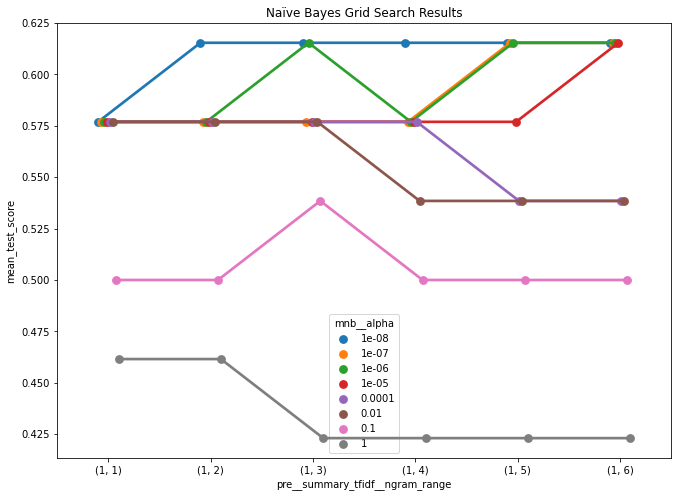

In [ ]:
with open(working_path/'models/gs_mnb.pkl.gzip', 'rb') as f:
  gs_mnb = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_mnb.cv_results_, 'pre__summary_tfidf__ngram_range', 'mnb__alpha')
plt.title('Naïve Bayes Grid Search Results')
plt.show()

Forecasting

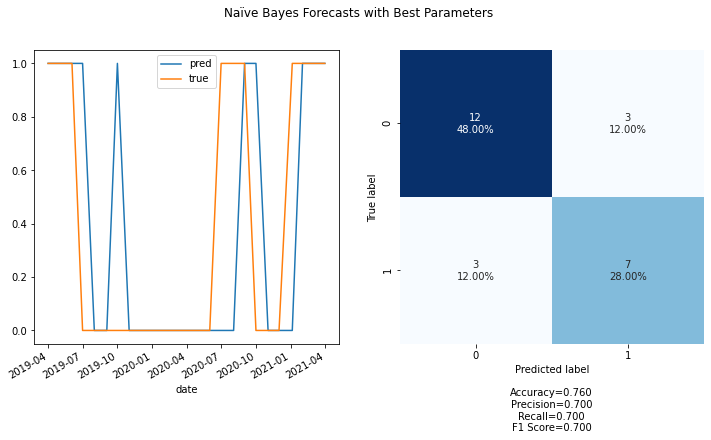

In [ ]:
# Using the best hyperparameters, 
mnb_pipeline.set_params(**gs_mnb.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
mnb_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)

# fit the pipeline on data from dates(0,t-1) and predict on date(t)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  mnb_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = mnb_pipeline.predict(X.loc[test_idx])
  mnb_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(mnb_pred, 'Naïve Bayes Forecasts with Best Parameters')

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([('pre', preprocessor),
                        ('lr', LogisticRegression(max_iter=100,
                                                  solver='liblinear',
                                                  class_weight='balanced'))],
                       memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'lr__penalty': ['l1', 'l2']}

In [ ]:
# gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_lr = gs_lr.fit(X_gs, y_gs)

# with open(working_path/'models/gs_lr.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_lr,f)

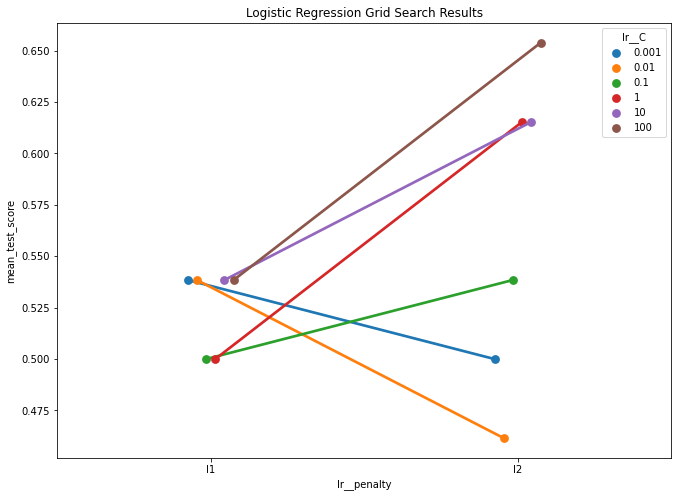

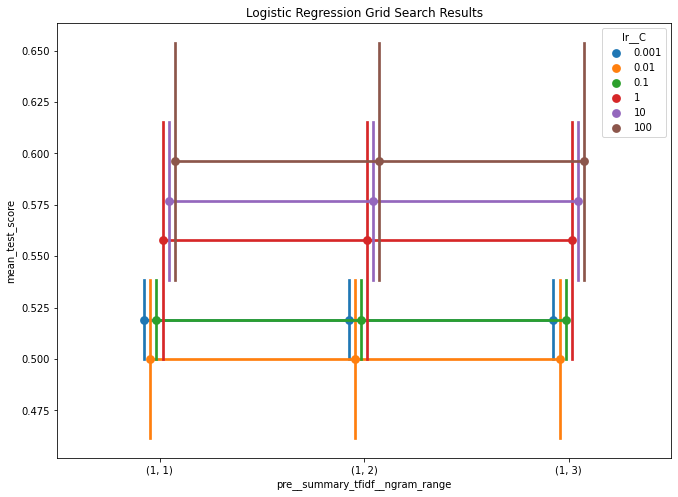

In [ ]:
with open(working_path/'models/gs_lr.pkl.gzip', 'rb') as f:
  gs_lr = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_lr.cv_results_, 'lr__penalty', 'lr__C')
plt.title('Logistic Regression Grid Search Results')

fig = plot_cv_results(gs_lr.cv_results_, 'pre__summary_tfidf__ngram_range', 'lr__C')
plt.title('Logistic Regression Grid Search Results');

Forecasting

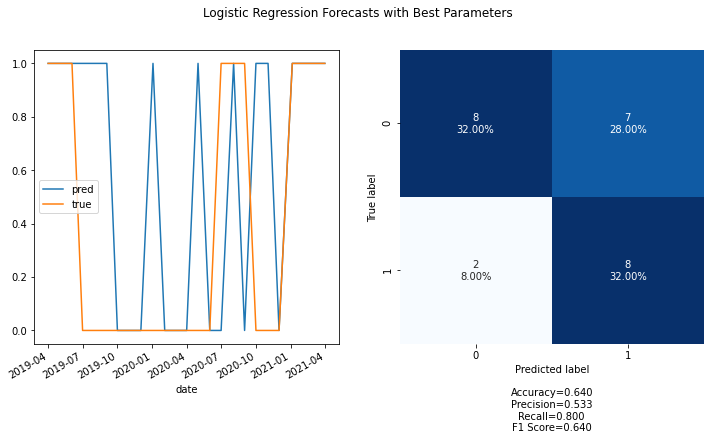

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
lr_pipeline.set_params(**gs_lr.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
lr_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  lr_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = lr_pipeline.predict(X.loc[test_idx])
  lr_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(lr_pred, 'Logistic Regression Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true_labels=true, predicted_labels=lr_pred)

Accuracy: 0.64
Precision: 0.6933
Recall: 0.64
F1 Score: 0.64


### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([('pre', preprocessor),
                        ('svm', LinearSVC(class_weight='balanced'))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'svm__C': [0.01, 0.1, 1, 5]
}

In [ ]:
# gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_svm = gs_svm.fit(X_gs, y_gs)

# with open(working_path/'models/gs_svm.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_svm,f)

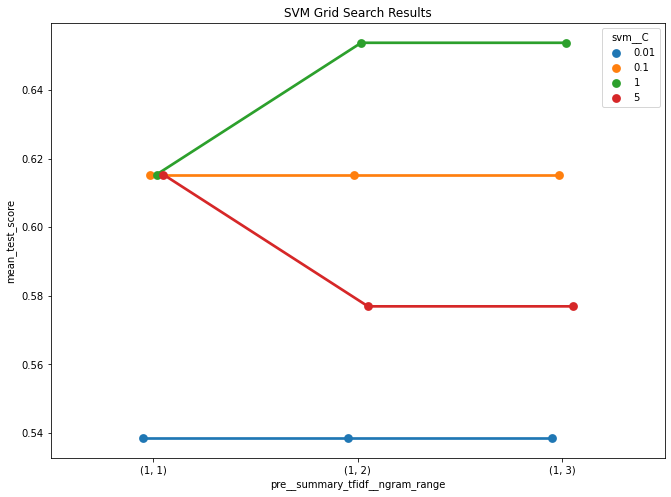

In [ ]:
with open(working_path/'models/gs_svm.pkl.gzip', 'rb') as f:
  gs_svm = pickle.load(f)

fig = plot_cv_results(gs_svm.cv_results_, 'pre__summary_tfidf__ngram_range', 'svm__C')
plt.title('SVM Grid Search Results');

Forecasting

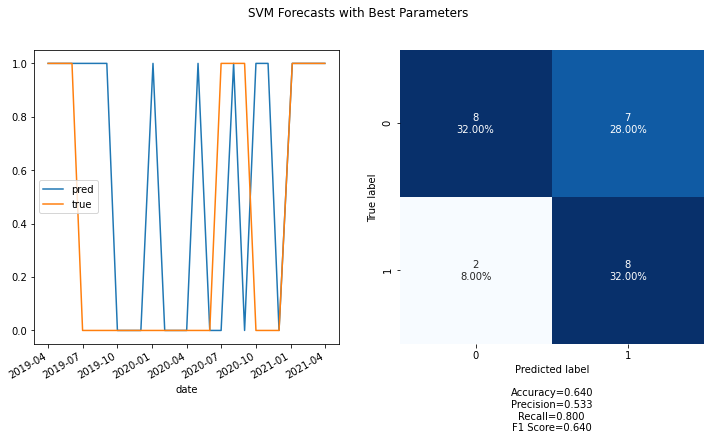

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
svm_pipeline.set_params(**gs_svm.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
svm_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  svm_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = svm_pipeline.predict(X.loc[test_idx])
  svm_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(svm_pred, 'SVM Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true_labels=true, predicted_labels=svm_pred)

Accuracy: 0.64
Precision: 0.6933
Recall: 0.64
F1 Score: 0.64


### Stochasitic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([('pre', preprocessor),
                        ('sgd', SGDClassifier(class_weight='balanced'))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

In [ ]:
# gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_sgd = gs_sgd.fit(X_gs, y_gs)

# with open(working_path/'models/gs_sgd.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_sgd,f)

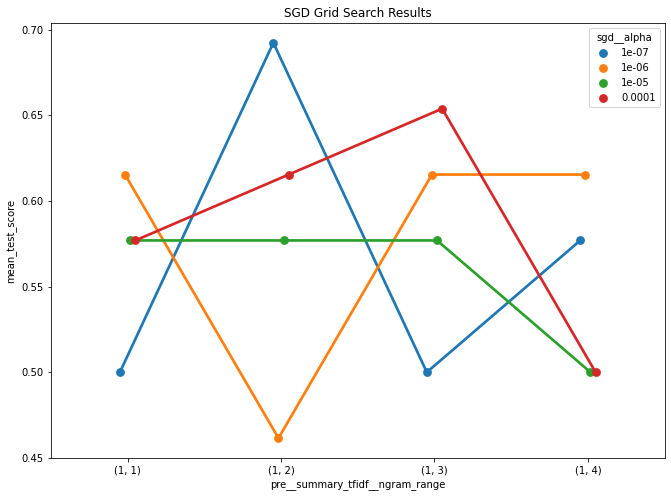

In [ ]:
with open(working_path/'models/gs_sgd.pkl.gzip', 'rb') as f:
  gs_sgd = pickle.load(f)

fig = plot_cv_results(gs_sgd.cv_results_, 'pre__summary_tfidf__ngram_range', 'sgd__alpha')
plt.title('SGD Grid Search Results');

Forecasting

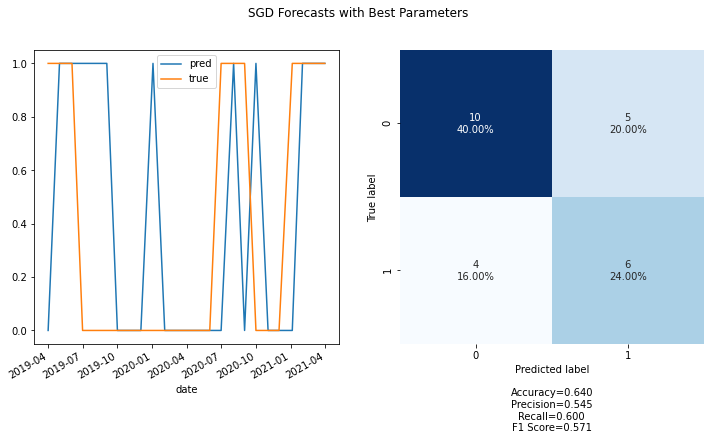

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
sgd_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  sgd_pipeline.set_params(**gs_sgd.best_params_)
  # Fit pipeline then predict
  sgd_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = sgd_pipeline.predict(X.loc[test_idx])
  sgd_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(sgd_pred, 'SGD Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true_labels=true, predicted_labels=sgd_pred)

Accuracy: 0.64
Precision: 0.6468
Recall: 0.64
F1 Score: 0.6424


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = Pipeline([('pre', preprocessor),
                        ('rfc', RandomForestClassifier())],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
              'rfc__n_estimators': [10, 50, 100, 200]
}

In [ ]:
# gs_rfc = GridSearchCV(rfc_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_rfc = gs_rfc.fit(X_gs, y_gs)

# with open(working_path/'models/gs_rfc.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_rfc,f)

Text(0.5, 1.0, 'Random Forest Grid Search Results')

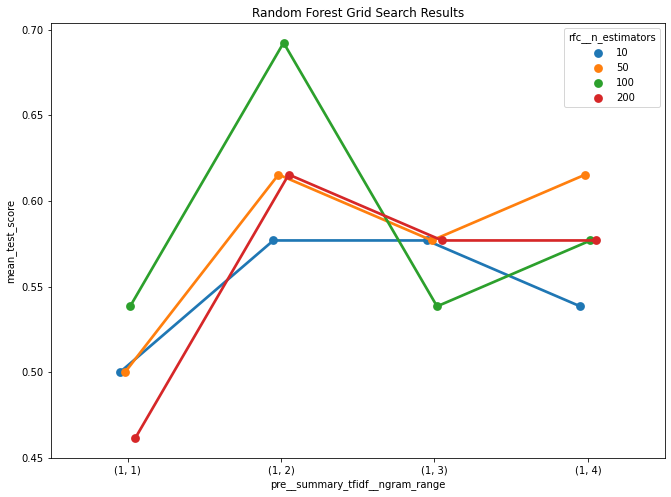

In [ ]:
with open(working_path/'models/gs_rfc.pkl.gzip', 'rb') as f:
  gs_rfc = pickle.load(f)

fig = plot_cv_results(gs_rfc.cv_results_, 'pre__summary_tfidf__ngram_range', 'rfc__n_estimators')
plt.title('Random Forest Grid Search Results')

Forecasting

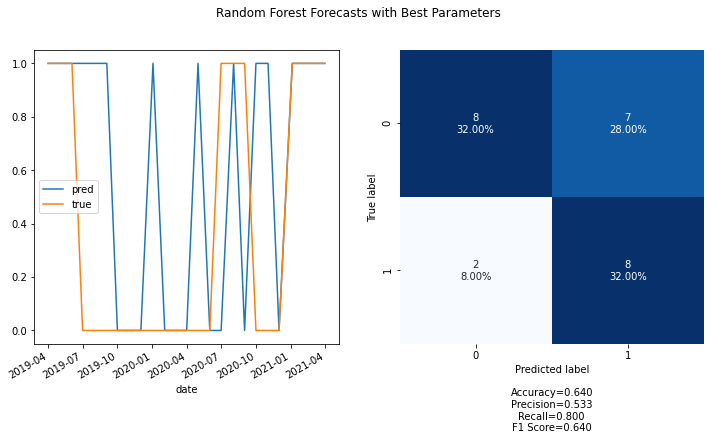

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
rfc_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  rfc_pipeline.set_params(**gs_rfc.best_params_)
  # Fit pipeline then predict
  rfc_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = rfc_pipeline.predict(X.loc[test_idx])
  rfc_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(svm_pred, 'Random Forest Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true_labels=true, predicted_labels=rfc_pred)

Accuracy: 0.64
Precision: 0.63
Recall: 0.64
F1 Score: 0.6057


### Gradient Boosting Machine (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipeline = Pipeline([('pre', preprocessor),
                        ('gbc', GradientBoostingClassifier())],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'gbc__n_estimators': [10, 50, 100, 200]}

In [ ]:
# gs_gbc = GridSearchCV(gbc_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_gbc = gs_gbc.fit(X_gs, y_gs)

# with open(working_path/'models/gs_gbc.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_gbc,f)

Text(0.5, 1.0, 'Gradient Boosting Machine Grid Search Results')

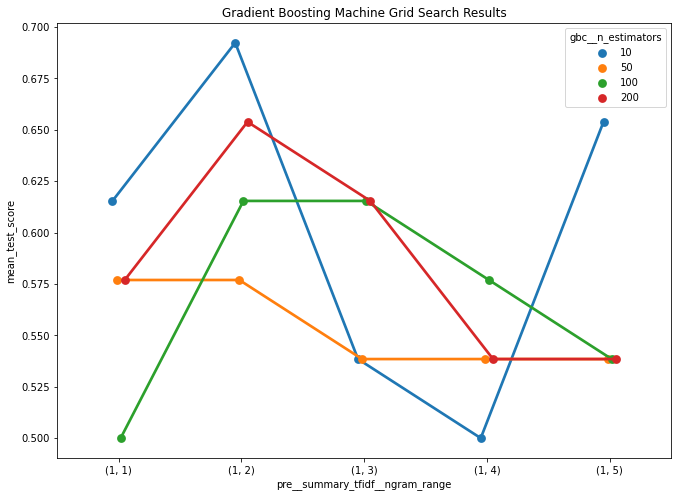

In [ ]:
with open(working_path/'models/gs_gbc.pkl.gzip', 'rb') as f:
  gs_gbc = pickle.load(f)

fig = plot_cv_results(gs_gbc.cv_results_, 'pre__summary_tfidf__ngram_range', 'gbc__n_estimators')
plt.title('Gradient Boosting Machine Grid Search Results')


Forecasting

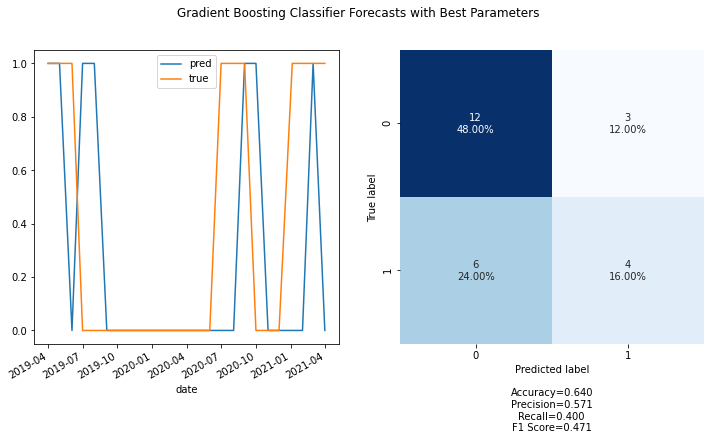

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
gbc_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  gbc_pipeline.set_params(**gs_gbc.best_params_)
  # Fit pipeline then predict
  gbc_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = gbc_pipeline.predict(X.loc[test_idx])
  gbc_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(gbc_pred, 'Gradient Boosting Classifier Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true_labels=true, predicted_labels=gbc_pred)

Accuracy: 0.64
Precision: 0.6286
Recall: 0.64
F1 Score: 0.6246


### Multi-layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline([('pre', preprocessor),
                         ('mlp', MLPClassifier(solver='adam', 
                                               learning_rate='adaptive', 
                                               early_stopping=True,
                                               activation = 'relu', 
                                               hidden_layer_sizes=(512, 512)))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'mlp__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

In [ ]:
# gs_mlp = GridSearchCV(mlp_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_mlp = gs_mlp.fit(X_gs, y_gs)

# with open(working_path/'models/gs_mlp.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_mlp,f)

Text(0.5, 1.0, 'Multi-layer Perceptron  Grid Search Results')

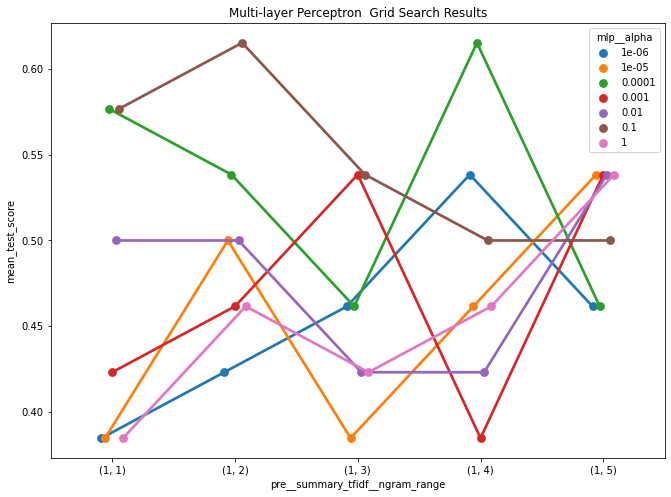

In [ ]:
with open(working_path/'models/gs_mlp.pkl.gzip', 'rb') as f:
  gs_mlp = pickle.load(f)

fig = plot_cv_results(gs_mlp.cv_results_, 'pre__summary_tfidf__ngram_range', 'mlp__alpha')
plt.title('Multi-layer Perceptron  Grid Search Results')

Best parameters: {'mlp__alpha': 0.0001, 'pre__summary_tfidf__ngram_range': (1, 4)}


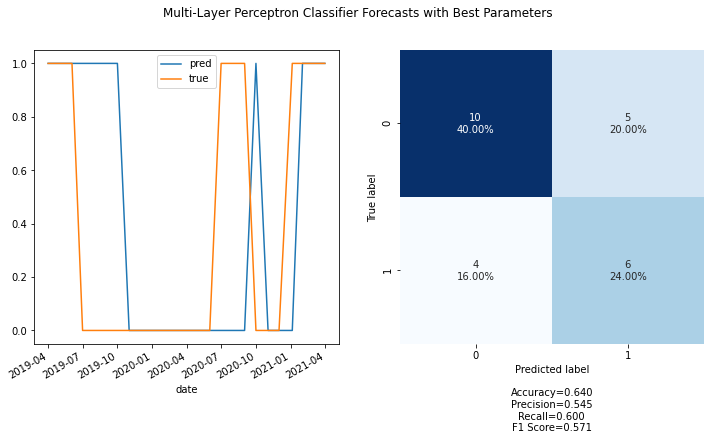

In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
print('Best parameters:', gs_mlp.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
mlp_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  mlp_pipeline.set_params(**gs_mlp.best_params_)
  # Fit pipeline then predict
  mlp_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = mlp_pipeline.predict(X.loc[test_idx])
  mlp_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(mlp_pred, 'Multi-Layer Perceptron Classifier Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true, mlp_pred)

Accuracy: 0.64
Precision: 0.6468
Recall: 0.64
F1 Score: 0.6424


## Compare word-based models

In [ ]:
word_based_models_preds = pd.DataFrame({'true': true,
                                      'mnb_pred': mnb_pred,
                                      'lr_pred': lr_pred,
                                      'svm_pred': svm_pred,
                                      'sgd_pred': sgd_pred,
                                      'rfc-pred': rfc_pred,
                                      'gbc_pred': gbc_pred,
                                      'mlp_pred': mlp_pred},
                                      index=true.index)
word_based_models_preds.tail()

,true,mnb_pred,lr_pred,svm_pred,sgd_pred,rfc-pred,gbc_pred,mlp_pred
date,,,,,,,,
2020-12-01,0,0,0,0,0,0,0,0
2021-01-05,1,0,1,1,0,0,0,0
2021-02-01,1,1,1,1,1,0,0,1
2021-03-01,1,1,1,1,1,0,1,1
2021-04-01,1,1,1,1,1,0,0,1


In [ ]:
word_based_models = pd.DataFrame([['Naive Bayes', 
               gs_mnb.cv_results_['mean_fit_time'].mean(), 
               gs_mnb.cv_results_['mean_score_time'].mean(),
               gs_mnb.cv_results_['mean_test_score'].mean()],
              ['Logistic Regression', 
               gs_lr.cv_results_['mean_fit_time'].mean(), 
               gs_lr.cv_results_['mean_score_time'].mean(),
               gs_lr.cv_results_['mean_test_score'].mean()],
              ['Linear SVM', 
               gs_svm.cv_results_['mean_fit_time'].mean(), 
               gs_svm.cv_results_['mean_score_time'].mean(),
               gs_svm.cv_results_['mean_test_score'].mean()],
              ['Linear SVM (SGD)', 
               gs_sgd.cv_results_['mean_fit_time'].mean(), 
               gs_sgd.cv_results_['mean_score_time'].mean(),
               gs_sgd.cv_results_['mean_test_score'].mean()],
              ['Random Forest', 
               gs_rfc.cv_results_['mean_fit_time'].mean(), 
               gs_rfc.cv_results_['mean_score_time'].mean(),
               gs_rfc.cv_results_['mean_test_score'].mean()],
              ['Gradient Boosted Machines', 
               gs_gbc.cv_results_['mean_fit_time'].mean(), 
               gs_gbc.cv_results_['mean_score_time'].mean(),
               gs_gbc.cv_results_['mean_test_score'].mean()],
              ['Multi-layer Perceptron', 
               gs_mlp.cv_results_['mean_fit_time'].mean(), 
               gs_mlp.cv_results_['mean_score_time'].mean(),
               gs_mlp.cv_results_['mean_test_score'].mean()]],
             columns=pd.Series(['Model', 'mean_fit_time', 'mean_score_time', 'mean_test_score'], name='Metric'),
             ).set_index('Model')
word_based_models

Metric,mean_fit_time,mean_score_time,mean_test_score
Model,,,
Naive Bayes,0.098620,0.011817,0.555288
Logistic Regression,0.038904,0.010786,0.544872
Linear SVM,0.041014,0.010925,0.596154
Linear SVM (SGD),0.052838,0.011996,0.572115
Random Forest,0.188363,0.020565,0.567308
Gradient Boosted Machines,1.108305,0.011813,0.576923
Multi-layer Perceptron,2.824963,0.018737,0.483516


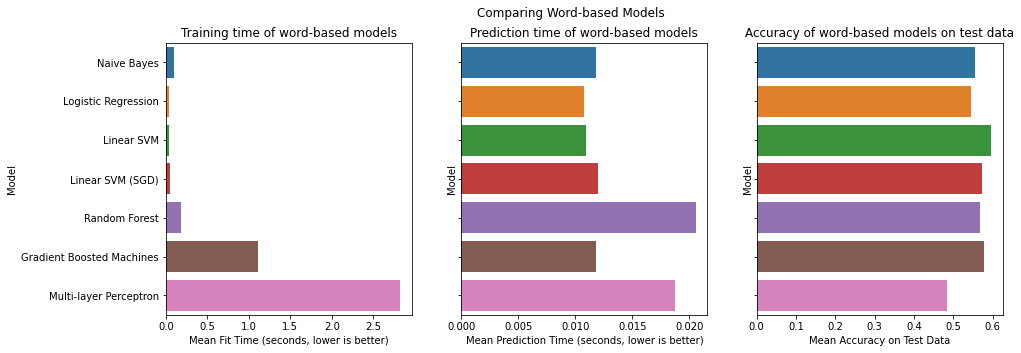

In [201]:
# Plot comparision of word-based models
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

g = sns.barplot(data=word_based_models.reset_index(),
                y='Model',
                x='mean_fit_time', ax=ax[0])
g.set(title='Training time of word-based models',
      xlabel='Mean Fit Time (seconds, lower is better)')

g = sns.barplot(data=word_based_models.reset_index(),
                y='Model',
                x='mean_score_time', ax=ax[1])
g.set(title='Prediction time of word-based models',
      xlabel='Mean Prediction Time (seconds, lower is better)')

g = sns.barplot(data=word_based_models.reset_index(),
                y='Model',
                x='mean_test_score', ax=ax[2])
g.set(title='Accuracy of word-based models on test data',
      xlabel='Mean Accuracy on Test Data')

plt.suptitle('Comparing Word-based Models');

The SVM methods performed best, though none of the models are good.

MLP model is worst performer and almost 100 times slower to fit than the best performing model. We will exclude the MLP model from further comparisions.

For further modeling, we'll consider only SGD and SVM.

## Modeling with context-based features

In [ ]:
# fit_hyperparameters_on_train_set_then_fit__and_forecast_one_period_ahead_test_set
def make_splits_fit_and_predict(X, y, pipeline, param_grid, model_name):
  # Make splits, outer
  validation_size = max(int(0.8*len(X)), 2)
  forecast_splits_outer = TimeSeriesSplit(n_splits=validation_size, test_size=1)

  # Init empty series               
  cv_results_list = []
  preds_and_true = y.rename('true').to_frame()
  for train_ilocs, test_iloc in tqdm(list(forecast_splits_outer.split(X))):
    #map ilocs to loc(date indexes)
    train_idxs = X.iloc[train_ilocs].index
    test_idx = y.iloc[test_iloc].index

    # Make splits, inner
    n_splits_inner = max(int(0.3*len(train_idxs)), 2)
    gs_splits_inner =  TimeSeriesSplit(n_splits=n_splits_inner, test_size=1)

    #Make Grid Search object and find best params on train data
    gscv = GridSearchCV(pipeline, param_grid, cv=gs_splits_inner)
    gscv = gscv.fit(X.loc[train_idxs], y.loc[train_idxs])

    # Using the best hyperparameters, 
    # fit the pipeline on data from dates(0 to t-1) and predict on date(t)
    pipeline.set_params(**gscv.best_params_)
    # Fit pipeline then predict
    pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
    forecast = pipeline.predict(X.loc[test_idx])
    # Add test date to cv_results
    gscv.cv_results_['asof_date'] = pd.Series(pd.to_datetime(np.full_like(gscv.cv_results_['mean_fit_time'], test_idx)))
    cv_results_list.append(gscv.cv_results_)
    preds_and_true.loc[test_idx, 'pred'] = forecast.item()

  cv_results = pd.concat([pd.DataFrame(ele) for ele in cv_results_list])
  preds_and_true = preds_and_true.dropna().astype(int)

  # Save model and cv_results
  with open(working_path/f'models/{model_name}.pkl.gzip', 'wb') as f:
    pickle.dump(pipeline, f)
  with open(working_path/f'cv_results/{model_name}.pkl.gzip', 'wb') as f:
    cv_results.to_pickle(f)
  with open(working_path/f'preds/{model_name}.pkl.gzip', 'wb') as f:
    preds_and_true.to_pickle(f)
  return pipeline, cv_results, preds_and_true

In [ ]:
# tokenize corpus
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()

tokenized_train = [tokenizer.tokenize(text)
                   for text in train_corpus]
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_corpus]

In [ ]:
def document_vectorizer(corpus, model, vector_size):
  vocabulary = set(model.wv.index_to_key)
  
  def average_word_vectors(words, model, vocabulary, vector_size):
    feature_vector = np.zeros((vector_size,), dtype="float64")
    nwords = 0.
    for word in words:
      if word in vocabulary: 
        nwords = nwords + 1.
        feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
      feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

  features = [average_word_vectors(tokenized_sentence, model, vocabulary, vector_size)
                  for tokenized_sentence in corpus]
  return np.array(features)

def normalize_document(doc, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, stopwords=stopword_list):
  # strip HTML
  if html_stripping:
      doc = strip_html_tags(doc)
  # remove accented characters
  if accented_char_removal:
      doc = remove_accented_chars(doc)
  # expand contractions    
  if contraction_expansion:
      doc = expand_contractions(doc)
  # lowercase the text    
  if text_lower_case:
      doc = doc.lower()
  # remove extra newlines
  doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
  # lemmatize text
  if text_lemmatization:
      doc = lemmatize_text(doc)
  # remove special characters and\or digits    
  if special_char_removal:
      # insert spaces between special characters to isolate them    
      special_char_pattern = re.compile(r'([{.(-)!}])')
      doc = special_char_pattern.sub(" \\1 ", doc)
      doc = remove_special_characters(doc, remove_digits=remove_digits)  
  # remove extra whitespace
  doc = re.sub(' +', ' ', doc)
  # remove stopwords
  if stopword_removal:
      doc = remove_stopwords(doc, is_lower_case=text_lower_case)
  return doc

### Word2Vec

Gensim implements the word2vec model

In [ ]:
# Make a sklearn wrapper for gensim Word2Vec
from sklearn.base import TransformerMixin, BaseEstimator
import gensim

class W2VTransformer(TransformerMixin, BaseEstimator):
    """Base Word2Vec module, wraps :class:`~gensim.models.word2vec.Word2Vec`.
    """
    def __init__(self, vector_size=20, window=30, min_count=2, sample=1e-3,alpha=0.025, max_vocab_size=None, seed=1,
                 workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, cbow_mean=1, hashfxn=hash, epochs=200, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000):
      """

      Parameters
      ----------
      vector_size : int
          Dimensionality of the feature vectors.
      window : int
          The maximum distance between the current and predicted word within a sentence.
      min_count : int
          Ignores all words with total frequency lower than this.
      sample : float
          The threshold for configuring which higher-frequency words are randomly downsampled,
          useful range is (0, 1e-5).
      alpha : float
          The initial learning rate.
      max_vocab_size : int
          Limits the RAM during vocabulary building; if there are more unique
          words than this, then prune the infrequent ones. Every 10 million word types need about 1GB of RAM.
          Set to `None` for no limit.
      seed : int
          Seed for the random number generator. Initial vectors for each word are seeded with a hash of
          the concatenation of word + `str(seed)`. Note that for a fully deterministically-reproducible run,
          you must also limit the model to a single worker thread (`workers=1`), to eliminate ordering jitter
          from OS thread scheduling. (In Python 3, reproducibility between interpreter launches also requires
          use of the `PYTHONHASHSEED` environment variable to control hash randomization).
      workers : int
          Use these many worker threads to train the model (=faster training with multicore machines).
      min_alpha : float
          Learning rate will linearly drop to `min_alpha` as training progresses.
      sg : int {1, 0}
          Defines the training algorithm. If 1, CBOW is used, otherwise, skip-gram is employed.
      hs : int {1,0}
          If 1, hierarchical softmax will be used for model training.
          If set to 0, and `negative` is non-zero, negative sampling will be used.
      negative : int
          If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
          should be drawn (usually between 5-20).
          If set to 0, no negative sampling is used.
      cbow_mean : int {1,0}
          If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
      hashfxn : callable (object -> int), optional
          A hashing function. Used to create an initial random reproducible vector by hashing the random seed.
      epochs : int
          Number of iterations (epochs) over the corpus.
      null_word : int {1, 0}
          If 1, a null pseudo-word will be created for padding when using concatenative L1 (run-of-words)
      trim_rule : function
          Vocabulary trimming rule, specifies whether certain words should remain in the vocabulary,
          be trimmed away, or handled using the default (discard if word count < min_count).
          Can be None (min_count will be used, look to :func:`~gensim.utils.keep_vocab_item`),
          or a callable that accepts parameters (word, count, min_count) and returns either
          :attr:`gensim.utils.RULE_DISCARD`, :attr:`gensim.utils.RULE_KEEP` or :attr:`gensim.utils.RULE_DEFAULT`.
          Note: The rule, if given, is only used to prune vocabulary during build_vocab() and is not stored as part
          of the model.
      sorted_vocab : int {1,0}
          If 1, sort the vocabulary by descending frequency before assigning word indexes.
      batch_words : int
          Target size (in words) for batches of examples passed to worker threads (and
          thus cython routines).(Larger batches will be passed if individual
          texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

      """
      self.gensim_model = None
      self.vector_size  = vector_size 
      self.alpha = alpha
      self.window = window
      self.min_count = min_count
      self.max_vocab_size = max_vocab_size
      self.sample = sample
      self.seed = seed
      self.workers = workers
      self.min_alpha = min_alpha
      self.sg = sg
      self.hs = hs
      self.negative = negative
      self.cbow_mean = int(cbow_mean)
      self.hashfxn = hashfxn
      self.epochs = epochs 
      self.null_word = null_word
      self.trim_rule = trim_rule
      self.sorted_vocab = sorted_vocab
      self.batch_words = batch_words

    def fit(self, X, y=None):
      """Fit the model according to the given training data.

      Parameters
      ----------
      X : iterable of iterables of str
          The input corpus. X can be simply a list of lists of tokens, but for larger corpora,
          consider an iterable that streams the sentences directly from disk/network.
          See :class:`~gensim.models.word2vec.BrownCorpus`, :class:`~gensim.models.word2vec.Text8Corpus`
          or :class:`~gensim.models.word2vec.LineSentence` in :mod:`~gensim.models.word2vec` module for such examples.

      Returns
      -------
      :class:`~gensim.sklearn_api.w2vmodel.W2VTransformer`
          The trained model.

      """
      self.gensim_model = gensim.models.Word2Vec(
          sentences=X, vector_size=self.vector_size, alpha=self.alpha,
          window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
          sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
          sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean,
          hashfxn=self.hashfxn, epochs=self.epochs , null_word=self.null_word, trim_rule=self.trim_rule,
          sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
      )
      return self

    def transform(self, X):
      """Get the word vectors the input words.

      Parameters
      ----------
      words : {iterable of str, str}
          Word or a collection of words to be transformed.

      Returns
      -------
      np.ndarray of shape [`len(words)`, `vector_size`]
          A 2D array where each row is the vector of one word.

      """
      if self.gensim_model is None:
          raise NotFittedError(
              "This model has not been fitted yet. Call 'fit' with appropriate arguments before using this method."
          )

      def document_vectorizer(corpus, model, vector_size):
        vocabulary = set(model.wv.index_to_key)
      
        def average_word_vectors(words, model, vocabulary, vector_size):
          feature_vector = np.zeros((vector_size,), dtype="float64")
          nwords = 0.
          for word in words:
            if word in vocabulary: 
              nwords = nwords + 1.
              feature_vector = np.add(feature_vector, model.wv[word])
          if nwords:
            feature_vector = np.divide(feature_vector, nwords)
          return feature_vector

        features = [average_word_vectors(tokenized_sentence, model, vocabulary, vector_size)
                      for tokenized_sentence in corpus]
        return np.array(features)
      
      # tokenize corpus
      from nltk.tokenize.toktok import ToktokTokenizer
      tokenizer = ToktokTokenizer()
      tokenized_X = [tokenizer.tokenize(text) for text in X]

      # words = [words]
      # vectors = [self.gensim_model.wv[word] for word in words]
      # return np.reshape(np.array(vectors), (len(words), self.vector_size))
      return document_vectorizer(tokenized_X, self.gensim_model, self.vector_size)

    def partial_fit(self, X):
      raise NotImplementedError(
          "'partial_fit' has not been implemented for W2VTransformer. "
          "However, the model can be updated with a fixed vocabulary using Gensim API call."
      )

In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()
summary_tokenized_train = [tokenizer.tokenize(text)
                   for text in df['summary']]
wras_tokenized_train = [tokenizer.tokenize(text)
                   for text in df['wras']]

preprocessor = ColumnTransformer(
                [("summary_vectorizer", W2VTransformer().fit(summary_tokenized_train), 'clean_summary'),
                ("wras_vectorizer", W2VTransformer().fit(wras_tokenized_train), 'clean_wras'),
                ('commod_names_up_cv', CountVectorizer(), 'commodities_up_in_price'),
                ('commod_names-down_cv', CountVectorizer(), 'commodities_down_in_price'),
                ('commod_names-short_cv', CountVectorizer(), 'commodities_in_short_supply'),
                ('commod_count_scaler', MinMaxScaler(), ['commodities_up_count',
                                                          'commodities_down_count',
                                                          'commodities_short_count'])])

#### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import LinearSVC

model_name = 'svm_w2v'

# svm_w2v_pipeline = Pipeline([('pre', preprocessor),
#                              ('svm', LinearSVC(class_weight='balanced', 
#                                                dual=True,
#                                                max_iter=2000))],
#                               memory=cachedir)

# param_grid = {'svm__loss': ['hinge', 'squared_hinge'],
#               'svm__C': [0.001, 0.01, 0.1, 1, 5]}

# (fitted_pipeline, 
#  cv_results, 
#  out_of_sample_preds) = make_splits_fit_and_predict(X, y, 
#                                                     pipeline=svm_w2v_pipeline, 
#                                                     param_grid=param_grid,
#                                                     model_name=model_name)
# # Visualize pipeline
# svm_w2v_pipeline

Pipeline(memory='/tmp/tmp6lgxcgrd',
         steps=[('pre',
                 ColumnTransformer(transformers=[('summary_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_summary'),
                                                 ('wras_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_wras'),
                                                 ('commod_names_up_cv',
                                                  CountVectorizer(),
                                                  'commodities_up_in_price'),
                                                 ('commod_names-down_cv',
                                                  CountVectorizer(),
                                                  'commodities_down_in_price'),
                                                 ('commod_names-short_cv',
                                                  CountVectorizer(),
                                                  'commodities_in_short_supply'),
                                                 ('commod_count_scaler',
                                                  MinMaxScaler(),
                                                  ['commodities_up_count',
                                                   'commodities_down_count',
                                                   'commodities_short_count'])])),
                ('svm',
                 LinearSVC(C=1, class_weight='balanced', loss='hinge',
                           max_iter=2000))])

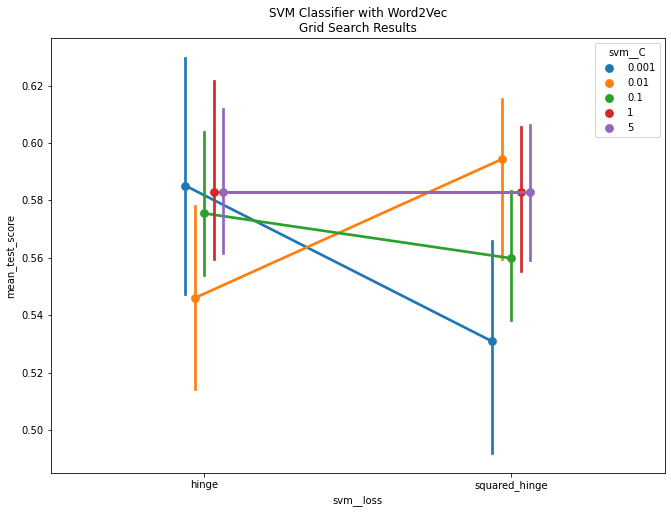

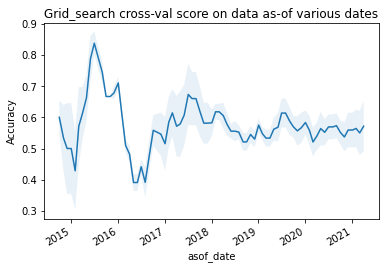

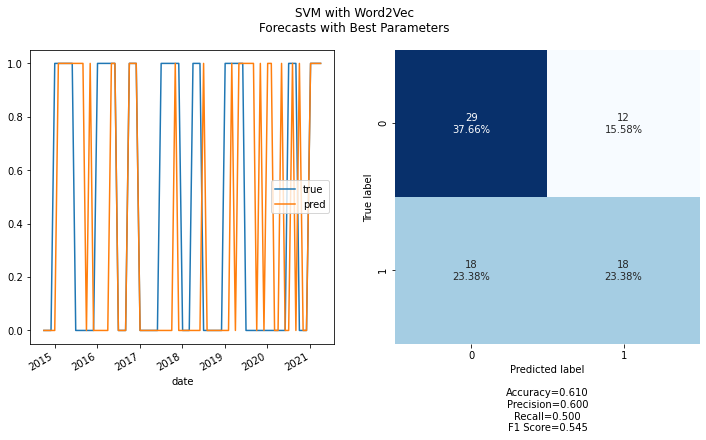

In [ ]:
model_name = 'svm_w2v'

# Load model and cv_results
with open(working_path/f'models/{model_name}.pkl.gzip', 'rb') as f:
  fitted_pipeline = pickle.load(f)
with open(working_path/f'cv_results/{model_name}.pkl.gzip', 'rb') as f:
  cv_results = pd.read_pickle(f)
with open(working_path/f'preds/{model_name}.pkl.gzip', 'rb') as f:
  out_of_sample_preds = pd.read_pickle(f)

# Plot grid search results
fig = plot_cv_results(cv_results, 'svm__loss', 'svm__C')
plt.title('SVM Classifier with Word2Vec\nGrid Search Results')

make_gscv_results_plot_asof_dates(cv_results)

# # Plot Forecast results
plot_forecasts(out_of_sample_preds,  'SVM with Word2Vec\nForecasts with Best Parameters')

#### Stochasitic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

model_name = 'sgd_w2v'

# pipeline = Pipeline([('pre', preprocessor),
#                              ('sgd', SGDClassifier(class_weight='balanced'))],
#                             memory=cachedir)

# param_grid = {'sgd__penalty': ['l1', 'l2'],
#               'sgd__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

# (fitted_pipeline, 
#  cv_results, 
#  out_of_sample_preds) = make_splits_fit_and_predict(X, y, 
#                                                     pipeline=pipeline, 
#                                                     param_grid=param_grid,
#                                                     model_name=model_name)
# # Visualize pipeline
# fitted_pipeline

Pipeline(memory='/tmp/tmp6lgxcgrd',
         steps=[('pre',
                 ColumnTransformer(transformers=[('summary_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_summary'),
                                                 ('wras_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_wras'),
                                                 ('commod_names_up_cv',
                                                  CountVectorizer(),
                                                  'commodities_up_in_price'),
                                                 ('commod_names-down_cv',
                                                  CountVectorizer(),
                                                  'commodities_down_in_price'),
                                                 ('commod_names-short_cv',
                                                  CountVectorizer(),
                                                  'commodities_in_short_supply'),
                                                 ('commod_count_scaler',
                                                  MinMaxScaler(),
                                                  ['commodities_up_count',
                                                   'commodities_down_count',
                                                   'commodities_short_count'])])),
                ('sgd',
                 SGDClassifier(alpha=1e-08, class_weight='balanced',
                               penalty='l1'))])

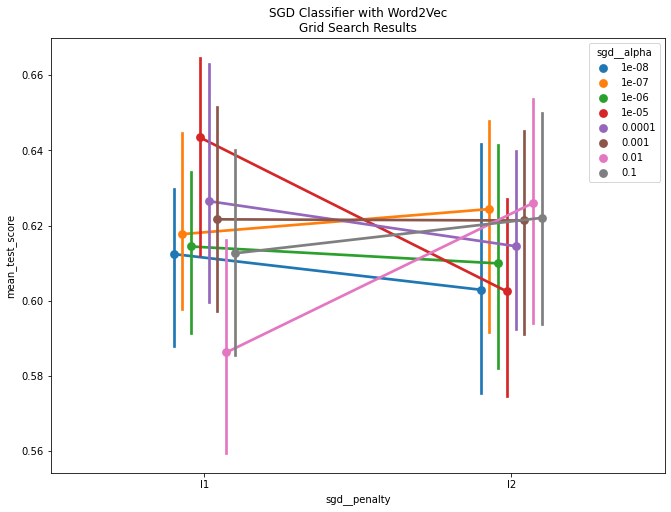

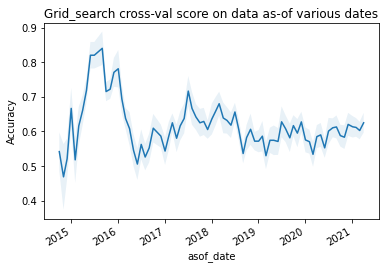

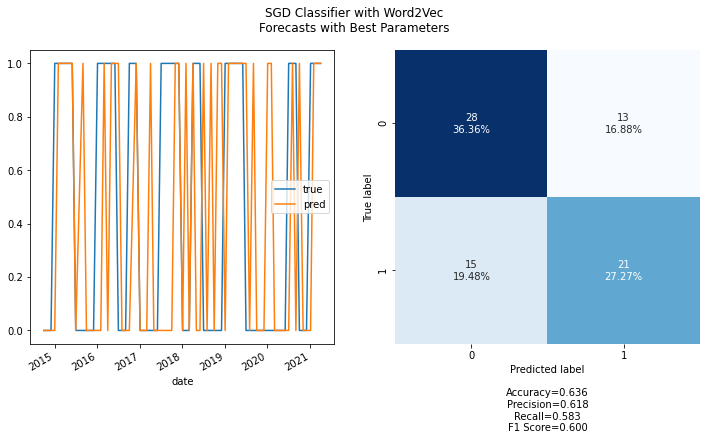

In [ ]:
model_name = 'sgd_w2v'

# Load model and cv_results
with open(working_path/f'models/{model_name}.pkl.gzip', 'rb') as f:
  fitted_pipeline = pickle.load(f)
with open(working_path/f'cv_results/{model_name}.pkl.gzip', 'rb') as f:
  cv_results = pd.read_pickle(f)
with open(working_path/f'preds/{model_name}.pkl.gzip', 'rb') as f:
  out_of_sample_preds = pd.read_pickle(f)

# Plot grid search results
fig = plot_cv_results(cv_results, 'sgd__penalty', 'sgd__alpha')
plt.title('SGD Classifier with Word2Vec\nGrid Search Results')

make_gscv_results_plot_asof_dates(cv_results)

# # Plot Forecast results
plot_forecasts(out_of_sample_preds, 'SGD Classifier with Word2Vec\nForecasts with Best Parameters')

#### Gradient Boosting Classifier (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# model_name = 'gbc_w2v'

# pipeline = Pipeline([('pre', preprocessor),
#                               ('gbc', GradientBoostingClassifier())],
#                               memory=cachedir)

# param_grid = {'gbc__learning_rate': [1e-3, 1e-2, 1e-1],
#               'gbc__n_estimators': [10, 50, 100, 200]}

# (fitted_pipeline, 
#  cv_results, 
#  out_of_sample_preds) = make_splits_fit_and_predict(X, y, 
#                                                     pipeline=pipeline, 
#                                                     param_grid=param_grid,
#                                                     model_name=model_name)
# # Visualize pipeline
# fitted_pipeline

Pipeline(memory='/tmp/tmp6lgxcgrd',
         steps=[('pre',
                 ColumnTransformer(transformers=[('summary_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_summary'),
                                                 ('wras_vectorizer',
                                                  W2VTransformer(),
                                                  'clean_wras'),
                                                 ('commod_names_up_cv',
                                                  CountVectorizer(),
                                                  'commodities_up_in_price'),
                                                 ('commod_names-down_cv',
                                                  CountVectorizer(),
                                                  'commodities_down_in_price'),
                                                 ('commod_names-short_cv',
                                                  CountVectorizer(),
                                                  'commodities_in_short_supply'),
                                                 ('commod_count_scaler',
                                                  MinMaxScaler(),
                                                  ['commodities_up_count',
                                                   'commodities_down_count',
                                                   'commodities_short_count'])])),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=10))])

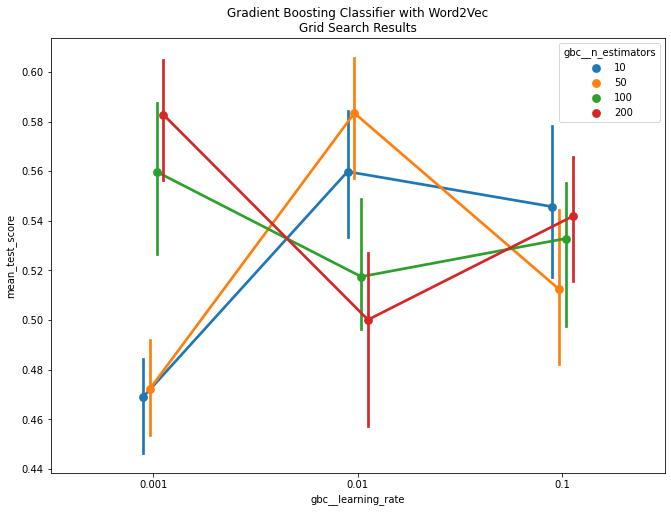

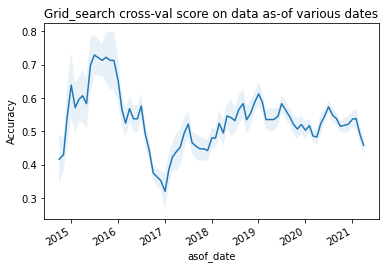

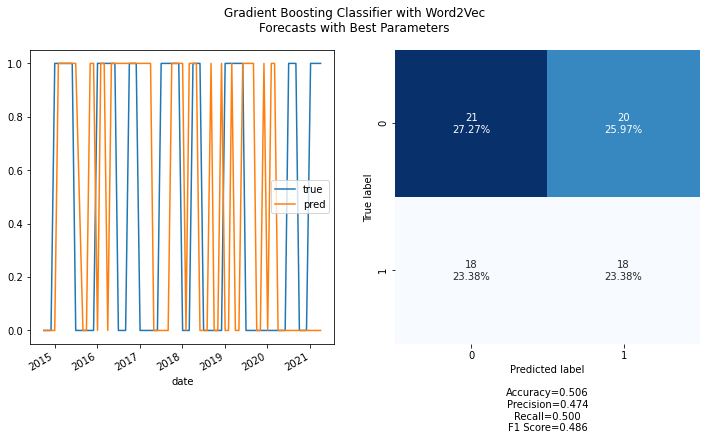

In [ ]:
model_name = 'gbc_w2v'

# Load model and cv_results
with open(working_path/f'models/{model_name}.pkl.gzip', 'rb') as f:
  fitted_pipeline = pickle.load(f)
with open(working_path/f'cv_results/{model_name}.pkl.gzip', 'rb') as f:
  cv_results = pd.read_pickle(f)
with open(working_path/f'preds/{model_name}.pkl.gzip', 'rb') as f:
  out_of_sample_preds = pd.read_pickle(f)

# Plot grid search results
fig = plot_cv_results(cv_results, 'gbc__learning_rate', 'gbc__n_estimators')
plt.title('Gradient Boosting Classifier with Word2Vec\nGrid Search Results')

make_gscv_results_plot_asof_dates(cv_results)

# # Plot Forecast results
plot_forecasts(out_of_sample_preds, 'Gradient Boosting Classifier with Word2Vec\nForecasts with Best Parameters')

## Compare context-based models

In [ ]:
# Load model and cv_results
with open(working_path/f'cv_results/svm_w2v.pkl.gzip', 'rb') as f:
  svm_w2v_cv_results = pd.read_pickle(f)
with open(working_path/f'cv_results/sgd_w2v.pkl.gzip', 'rb') as f:
  sgd_w2v_cv_results = pd.read_pickle(f)
with open(working_path/f'cv_results/gbc_w2v.pkl.gzip', 'rb') as f:
  gbc_w2v_cv_results = pd.read_pickle(f)

context_based_models = pd.DataFrame([['SVM with Word2Vec', 
               svm_w2v_cv_results['mean_fit_time'].mean(), 
               svm_w2v_cv_results['mean_score_time'].mean(),
               svm_w2v_cv_results['mean_test_score'].mean()],
              ['SGD with Word2Vec', 
               sgd_w2v_cv_results['mean_fit_time'].mean(), 
               sgd_w2v_cv_results['mean_score_time'].mean(),
               sgd_w2v_cv_results['mean_test_score'].mean()],
              ['GBM with Word2Vec', 
               gbc_w2v_cv_results['mean_fit_time'].mean(), 
               gbc_w2v_cv_results['mean_score_time'].mean(),
               gbc_w2v_cv_results['mean_test_score'].mean()]],
             columns=pd.Series(['Model', 
                                'mean_fit_time', 
                                'mean_score_time', 
                                'mean_test_score'], name='Metric'),
             ).set_index('Model')
context_based_models

Metric,mean_fit_time,mean_score_time,mean_test_score
Model,,,
SVM with Word2Vec,0.021697,0.008418,0.572390
SGD with Word2Vec,0.021164,0.008513,0.616152
GBM with Word2Vec,0.118631,0.008744,0.531464


Text(0.5, 0.98, 'Comparing Context-based Models')

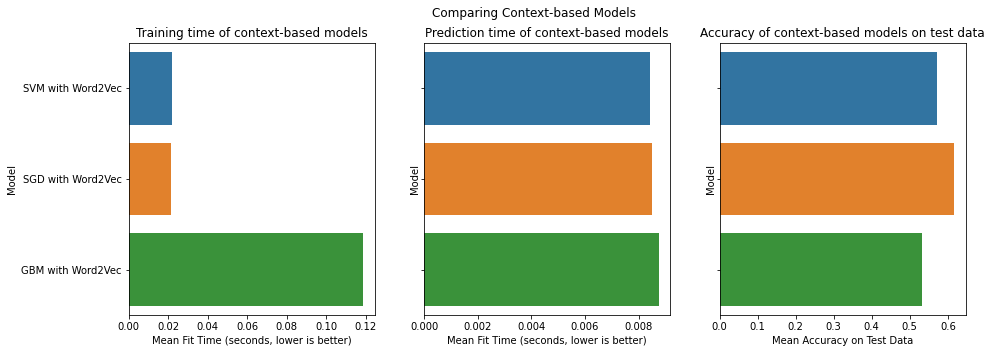

In [199]:
# Plot comparision of context-based models
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

g = sns.barplot(data=context_based_models.reset_index(),
                y='Model',
                x='mean_fit_time', ax=ax[0])
g.set(title='Training time of context-based models',
      xlabel='Mean Fit Time (seconds, lower is better)')

g = sns.barplot(data=context_based_models.reset_index(),
                y='Model',
                x='mean_score_time', ax=ax[1])
g.set(title='Prediction time of context-based models',
      xlabel='Mean Fit Time (seconds, lower is better)')

g = sns.barplot(data=context_based_models.reset_index(),
                y='Model',
                x='mean_test_score', ax=ax[2])
g.set(title='Accuracy of context-based models on test data',
      xlabel='Mean Accuracy on Test Data')

plt.suptitle('Comparing Context-based Models')

## Compare word-based models with context-based models

In [ ]:
word_and_context_based_models = word_based_models.append(context_based_models)
word_and_context_based_models

Metric,mean_fit_time,mean_score_time,mean_test_score
Model,,,
Naive Bayes,0.098620,0.011817,0.555288
Logistic Regression,0.038904,0.010786,0.544872
Linear SVM,0.041014,0.010925,0.596154
Linear SVM (SGD),0.052838,0.011996,0.572115
Random Forest,0.188363,0.020565,0.567308
Gradient Boosted Machines,1.108305,0.011813,0.576923
Multi-layer Perceptron,2.824963,0.018737,0.483516
SVM with Word2Vec,0.021697,0.008418,0.572390
SGD with Word2Vec,0.021164,0.008513,0.616152


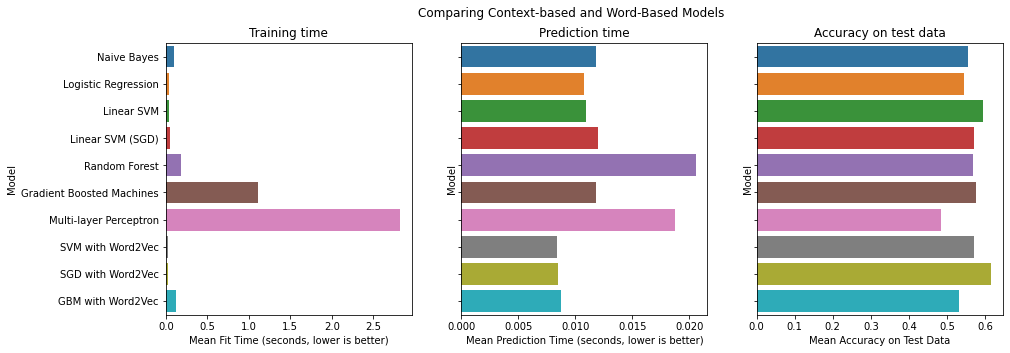

In [ ]:
# Plot comparision of word-based and context-based models
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

g = sns.barplot(data=word_and_context_based_models.reset_index(),
                y='Model',
                x='mean_fit_time', ax=ax[0])
g.set(title='Training time',
      xlabel='Mean Fit Time (seconds, lower is better)')

g = sns.barplot(data=word_and_context_based_models.reset_index(),
                y='Model',
                x='mean_score_time', ax=ax[1])
g.set(title='Prediction time',
      xlabel='Mean Prediction Time (seconds, lower is better)')

g = sns.barplot(data=word_and_context_based_models.reset_index(),
                y='Model',
                x='mean_test_score', ax=ax[2])
g.set(title='Accuracy on test data',
      xlabel='Mean Accuracy on Test Data')

plt.suptitle('Comparing Context-based and Word-Based Models');

# Feature Importance

In [ ]:
import eli5

# Load best model
model_name = 'sgd_w2v'
with open(working_path/f'models/{model_name}.pkl.gzip', 'rb') as f:
  fitted_pipeline = pickle.load(f)

eli5.show_weights(fitted_pipeline.named_steps.sgd)

Weight?,Feature
+2947.953,x326
+2321.305,x180
+2270.329,x89
+1505.200,x78
+1505.200,x233
+1304.524,x211
+1223.142,x185
+1210.410,x81
+1199.555,x23
+1172.850,x324


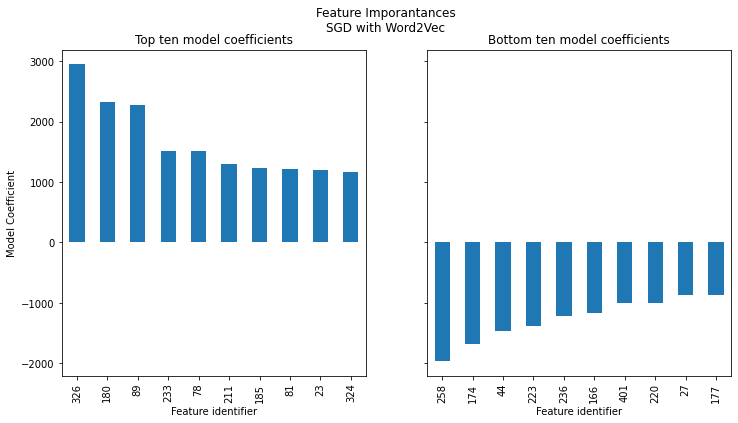

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
pd.Series(fitted_pipeline.named_steps.sgd.coef_.squeeze()).sort_values(ascending=False).iloc[:10].plot(kind='bar', ax=ax[0])
pd.Series(fitted_pipeline.named_steps.sgd.coef_.squeeze()).sort_values().iloc[:10].plot(kind='bar', ax=ax[1])
plt.suptitle('Feature Imporantances\nSGD with Word2Vec')
ax[0].set_title('Top ten model coefficients')
ax[0].set_xlabel('Feature identifier')
ax[0].set_ylabel('Model Coefficient')
ax[1].set_title('Bottom ten model coefficients')
ax[1].set_xlabel('Feature identifier');

The word2vec model does not having meaningful feature names. Without feature names, this isn't a very readiable format.



# Conclusion

Using the textual data scraped from the most recent monthly release of the ISM Report on Business, it is possible to predict the direction (positive or negative) of GDP growth (adjusted for seasonaility and trend) in the subsequent GDP release with an accuracy of 62%.

The accuracy on 74 out-of-sample predictions was not signifcantly different from the cross-validated accuracy, so we can be confident that the model has not been overfit.

The Word2Vec word embeddings performed much better than the TFIDF and word count embeddings.

# Limitations of this Analysis and Further Work

## Small dataset

The historical dataset spans over 70 years, but the textual data in this analysis only spans nine years.

While the historical numerical data in this data series are quite easy to find, as id the newest full release. However, the historical full text data series is quite difficult to find on the public web. Due to licensing and copyright issues, as well as limited access to the archival data, this analysis only considered textual data that could be found still published on a public news outlet's website.

*Further work: license the older data for research purposes, or find an institution that will share thier access to the archival data text.*



## Model has no memory of previous data in the time-series 
These models use only the most recent data as features when predicting the gdp_growth_direction. It may be useful for the models if they could learn from the features and targets of previous periods.

*Further work: Add creation of rolling windows to the preprocessing pipeline.*

## Some advanced word embeddings are absent from the final model

The word embeddings compared in this analysis are well-studied and easy to understand and explain. However, this means that the newest vectorizer compared here was first published in 2013 (Word2Vec). There are many newer vectorizers that may have performace improvements. Candidates for next comparsions include [GloVe (2014)](https://www.aclweb.org/anthology/D14-1162/) and [fastText (2016)](https://arxiv.org/abs/1607.04606v2) because they already have open-source python implementations. These two vectorizers have different approaches to making the word embeddings. It could be interesting to see if the novel approaches result in better performance. 

*Further work: Add FastText and GloVe word embeddings to the comparison*

## Topic embeddings are absent from the final comparison

Topic embedding were considered in the data exploration but were left out of the final comparision as combining these embeddings into a model with word2vec embeddings would be computationally costly on a single machine. By adapting code in this notebook for distributed computing, a larger model consisting of topic embeddings along with more advanced word embedding can be evaluated.

*Further work: Adapt the code for distrubuted computing to compute the performance of larger models containing words embeddings, as well as topic embeddings and content-embeddings.*